# Earth Engine for gathering data

Google Earth Engine is a powerful tool for geospatial data analysis. Here, we will discuss how to use its Python API for gathering data from Landsat, Sentinel, and NAIP imagery.

To start off with, request access to Google Earth Engine at: [](https://earthengine.google.com/). This may take some time. Once approved, install the Python API and get credentials for using the API following [these instructions](https://developers.google.com/earth-engine/guides/python_install-conda#mac_6). Be sure to try out the test code they suggest to make sure Earth Engine is running successfully):

In [121]:
import numpy as np
import zipfile
import rasterio
import matplotlib.pyplot as plt
import cv2
import math
from geetools import batch

In [70]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

If the above code yields output, you'll know you're ready for to go!

## Selecting imagery



In [95]:
def download_S2_toLocal(bbox, name, scale=1):
    """
    downloads Sentinel 2 imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterDate('2020-09-01', '2020-09-10')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
        .filterBounds(AOI)
        .select(['B2', 'B3', 'B4'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)
    return collection

# center of image (base of plant)
x = 38.2636
y = -85.8381

# lat long of image
# will vary based on the surface of the earth
lat = [x-0.004, x+0.004]
lon = [y-0.004, y+0.004]
bbox = [lon[0], lat[0], lon[1], lat[1]]
name = 's2sample4'
image = download_S2_toLocal(bbox, name, scale=1)

In [96]:
path_to_zip_file = 's2sample4.zip'
directory_to_extract_to = 's2sample4'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [97]:
def stack_bands_s2(name, outname):
    file_list = [name + '.B4.tif', name + '.B3.tif', name + '.B2.tif']

    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(outname, 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

outname = "stacked_s2_sample4.tif"
stack_bands_s2('s2sample4/download',outname)

### Gallagher

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


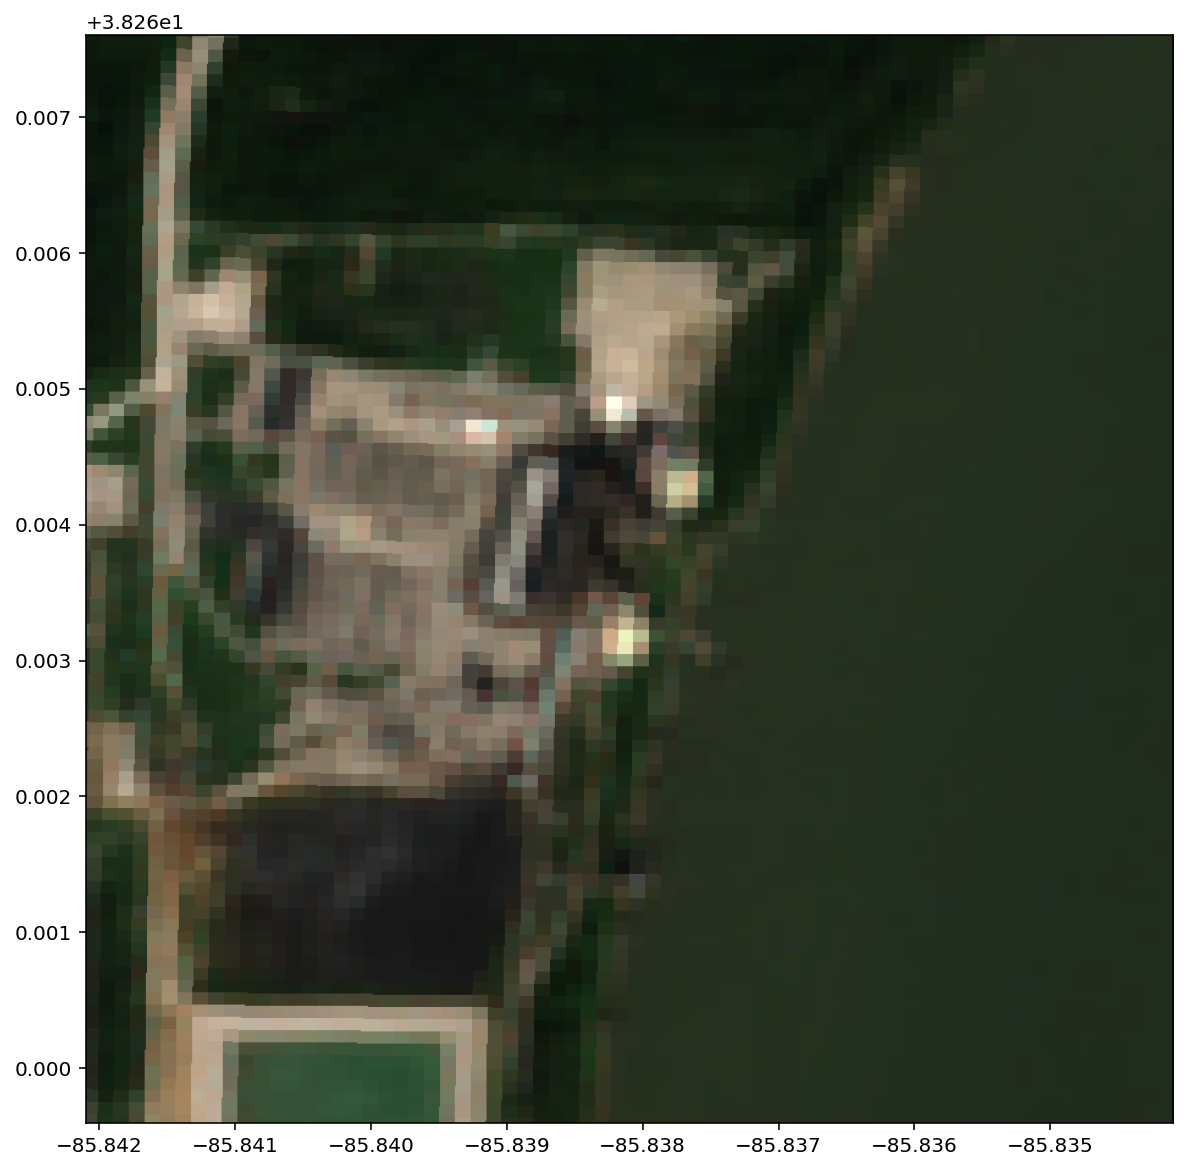

In [98]:
outname = "stacked_s2_sample4.tif"
# Plot the example
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(num='main', figsize=(10,10))

from rasterio.plot import show
data = rasterio.open(outname)

# show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
plt.savefig(r'hardin.jpg')

# show(data.read([1,2,3]).astype('float')/255, transform=data.transform, ax=ax)

## Load Image as NumPy Array

In [99]:
# load image as numpy array
with rasterio.open('stacked_s2_sample4.tif') as ds:
    img_arr = ds.read()  # read all raster values

In [100]:
img_arr.shape

(3, 891, 891)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


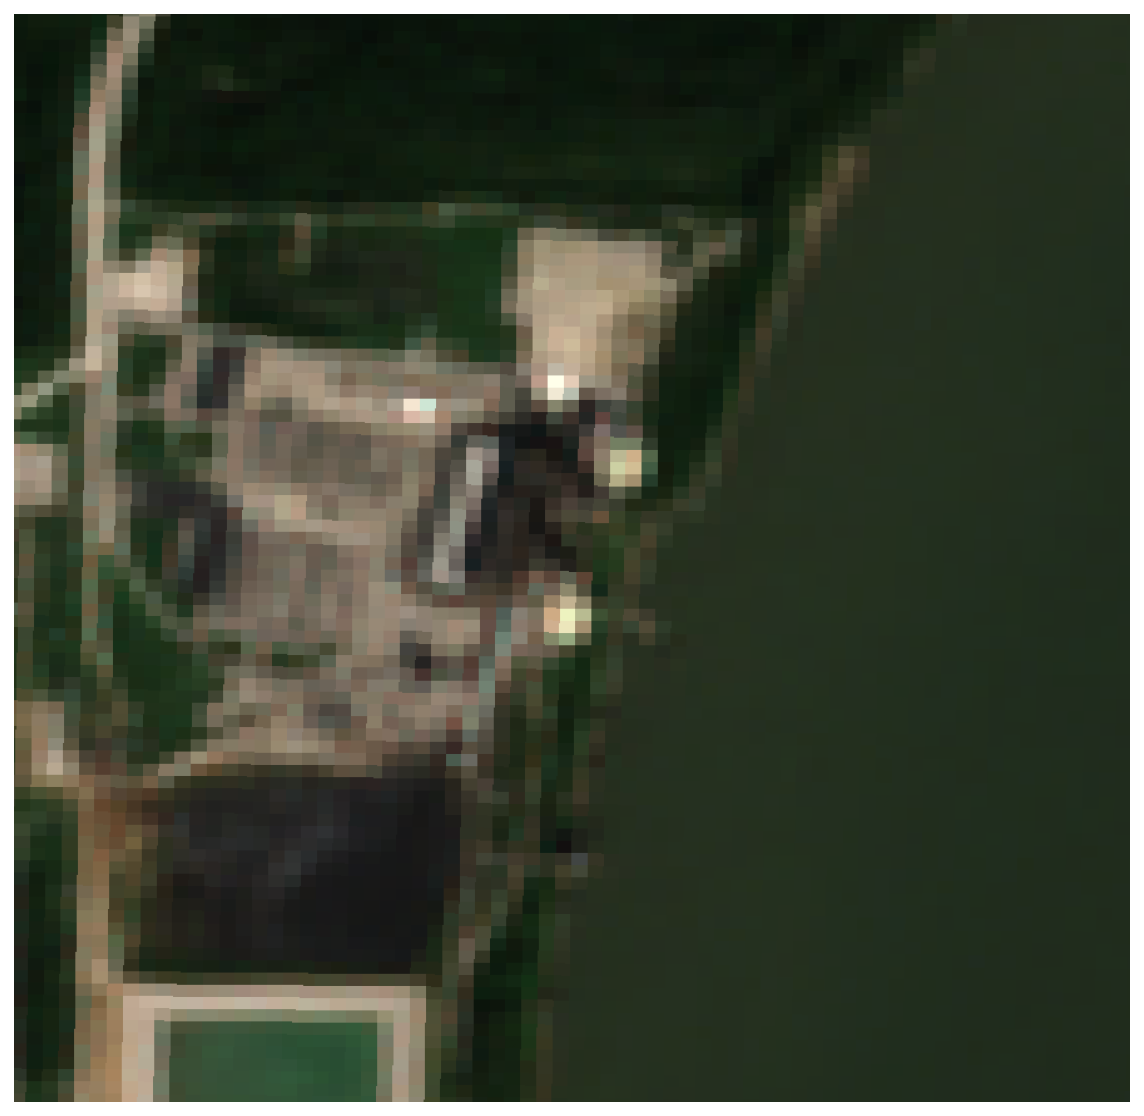

In [101]:
# try numpy swap axis, use this --> *move axis, roll axis
img_arr = np.moveaxis(img_arr, 0, -1)
img_arr = img_arr/4095
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_arr, aspect = 'auto')

In [102]:
img_arr.shape

(891, 891, 3)

### Convert image to grayscale?

In [103]:
# take average of each band -- create grayscale image
img_arr_bw = np.average(img_arr, weights=[0.1140, 0.5870, 0.2989], axis=2)

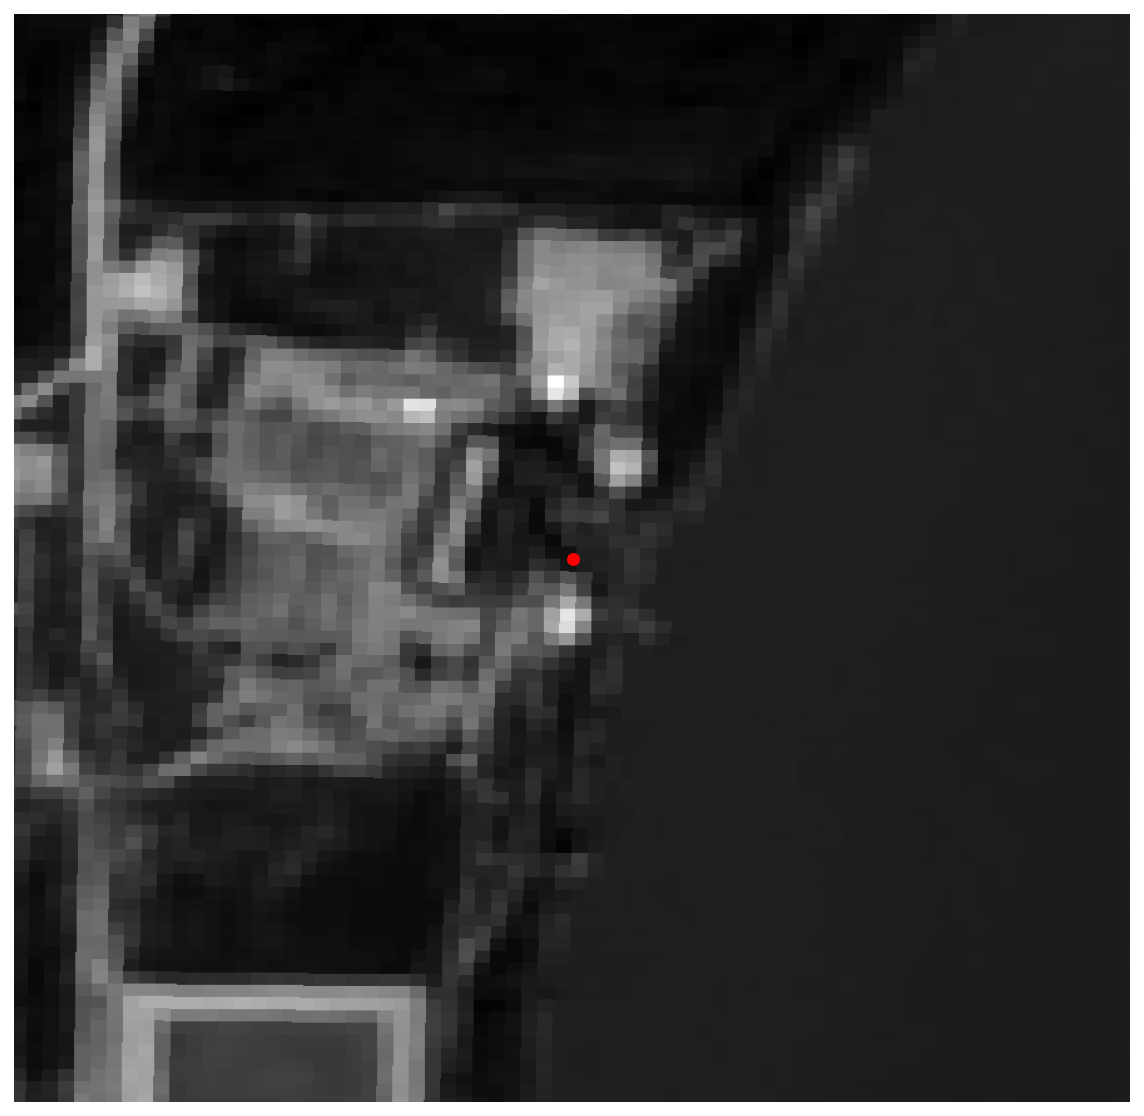

In [104]:
# true color of averaged image?
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_arr_bw, aspect = 'auto', cmap ='gray')
plt.scatter(891/2,891/2, c='red', s=30)
plt.show()

In [107]:
# select threshold
img_seg = np.where(img_arr_bw < 0.24, 0, 1)

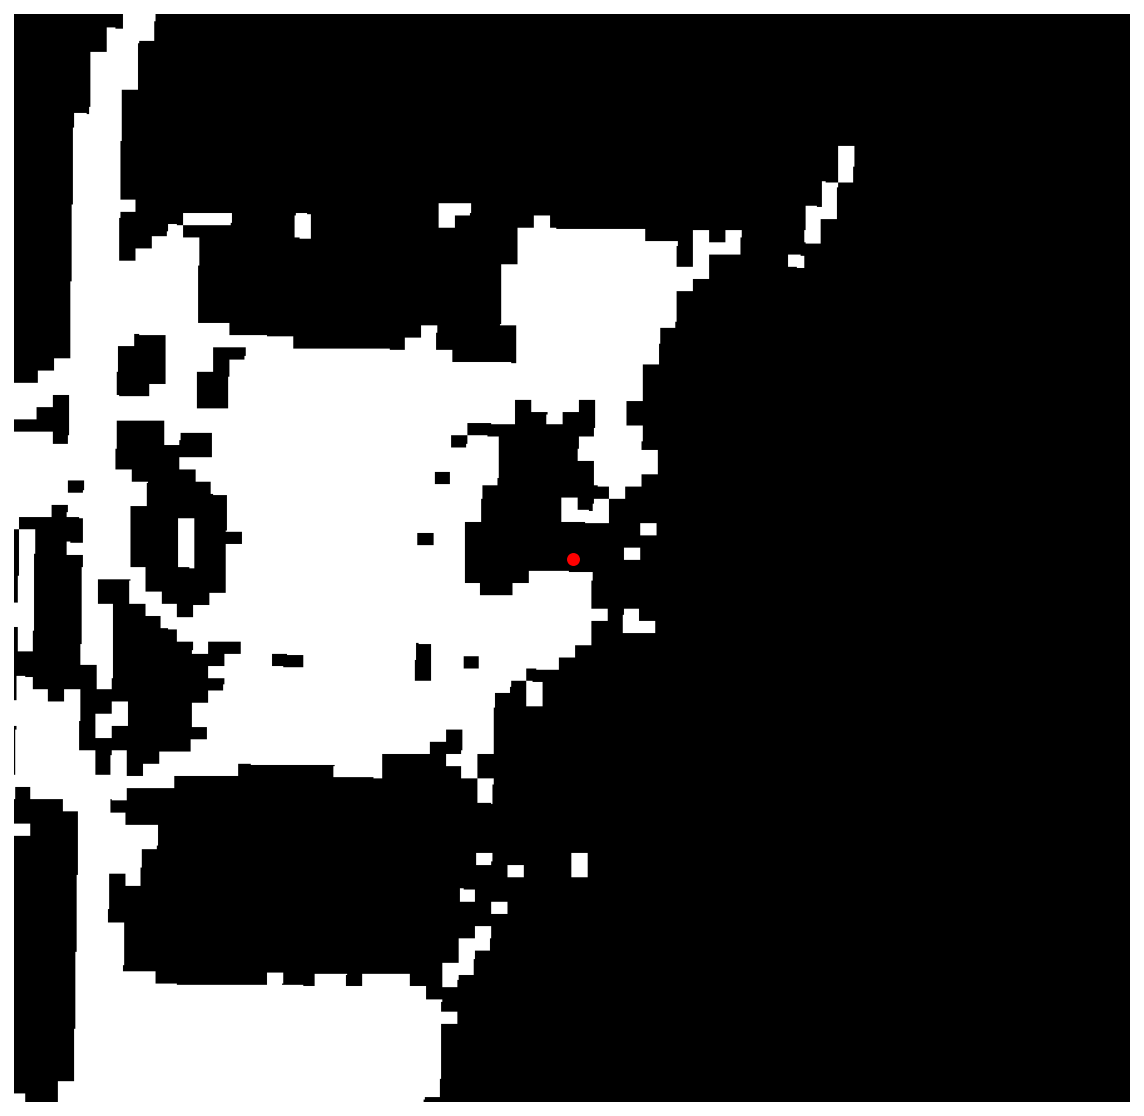

In [108]:
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_seg, aspect = 'auto', cmap ='gray')
plt.scatter(891/2,891/2, c='red', s=30)
plt.show()

### Thresholding Scikit Learn

Histogram-based: The histogram of the pixels’ intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal).

Local: To process a pixel, only the neighboring pixels are used. These algorithms often require more computation time.

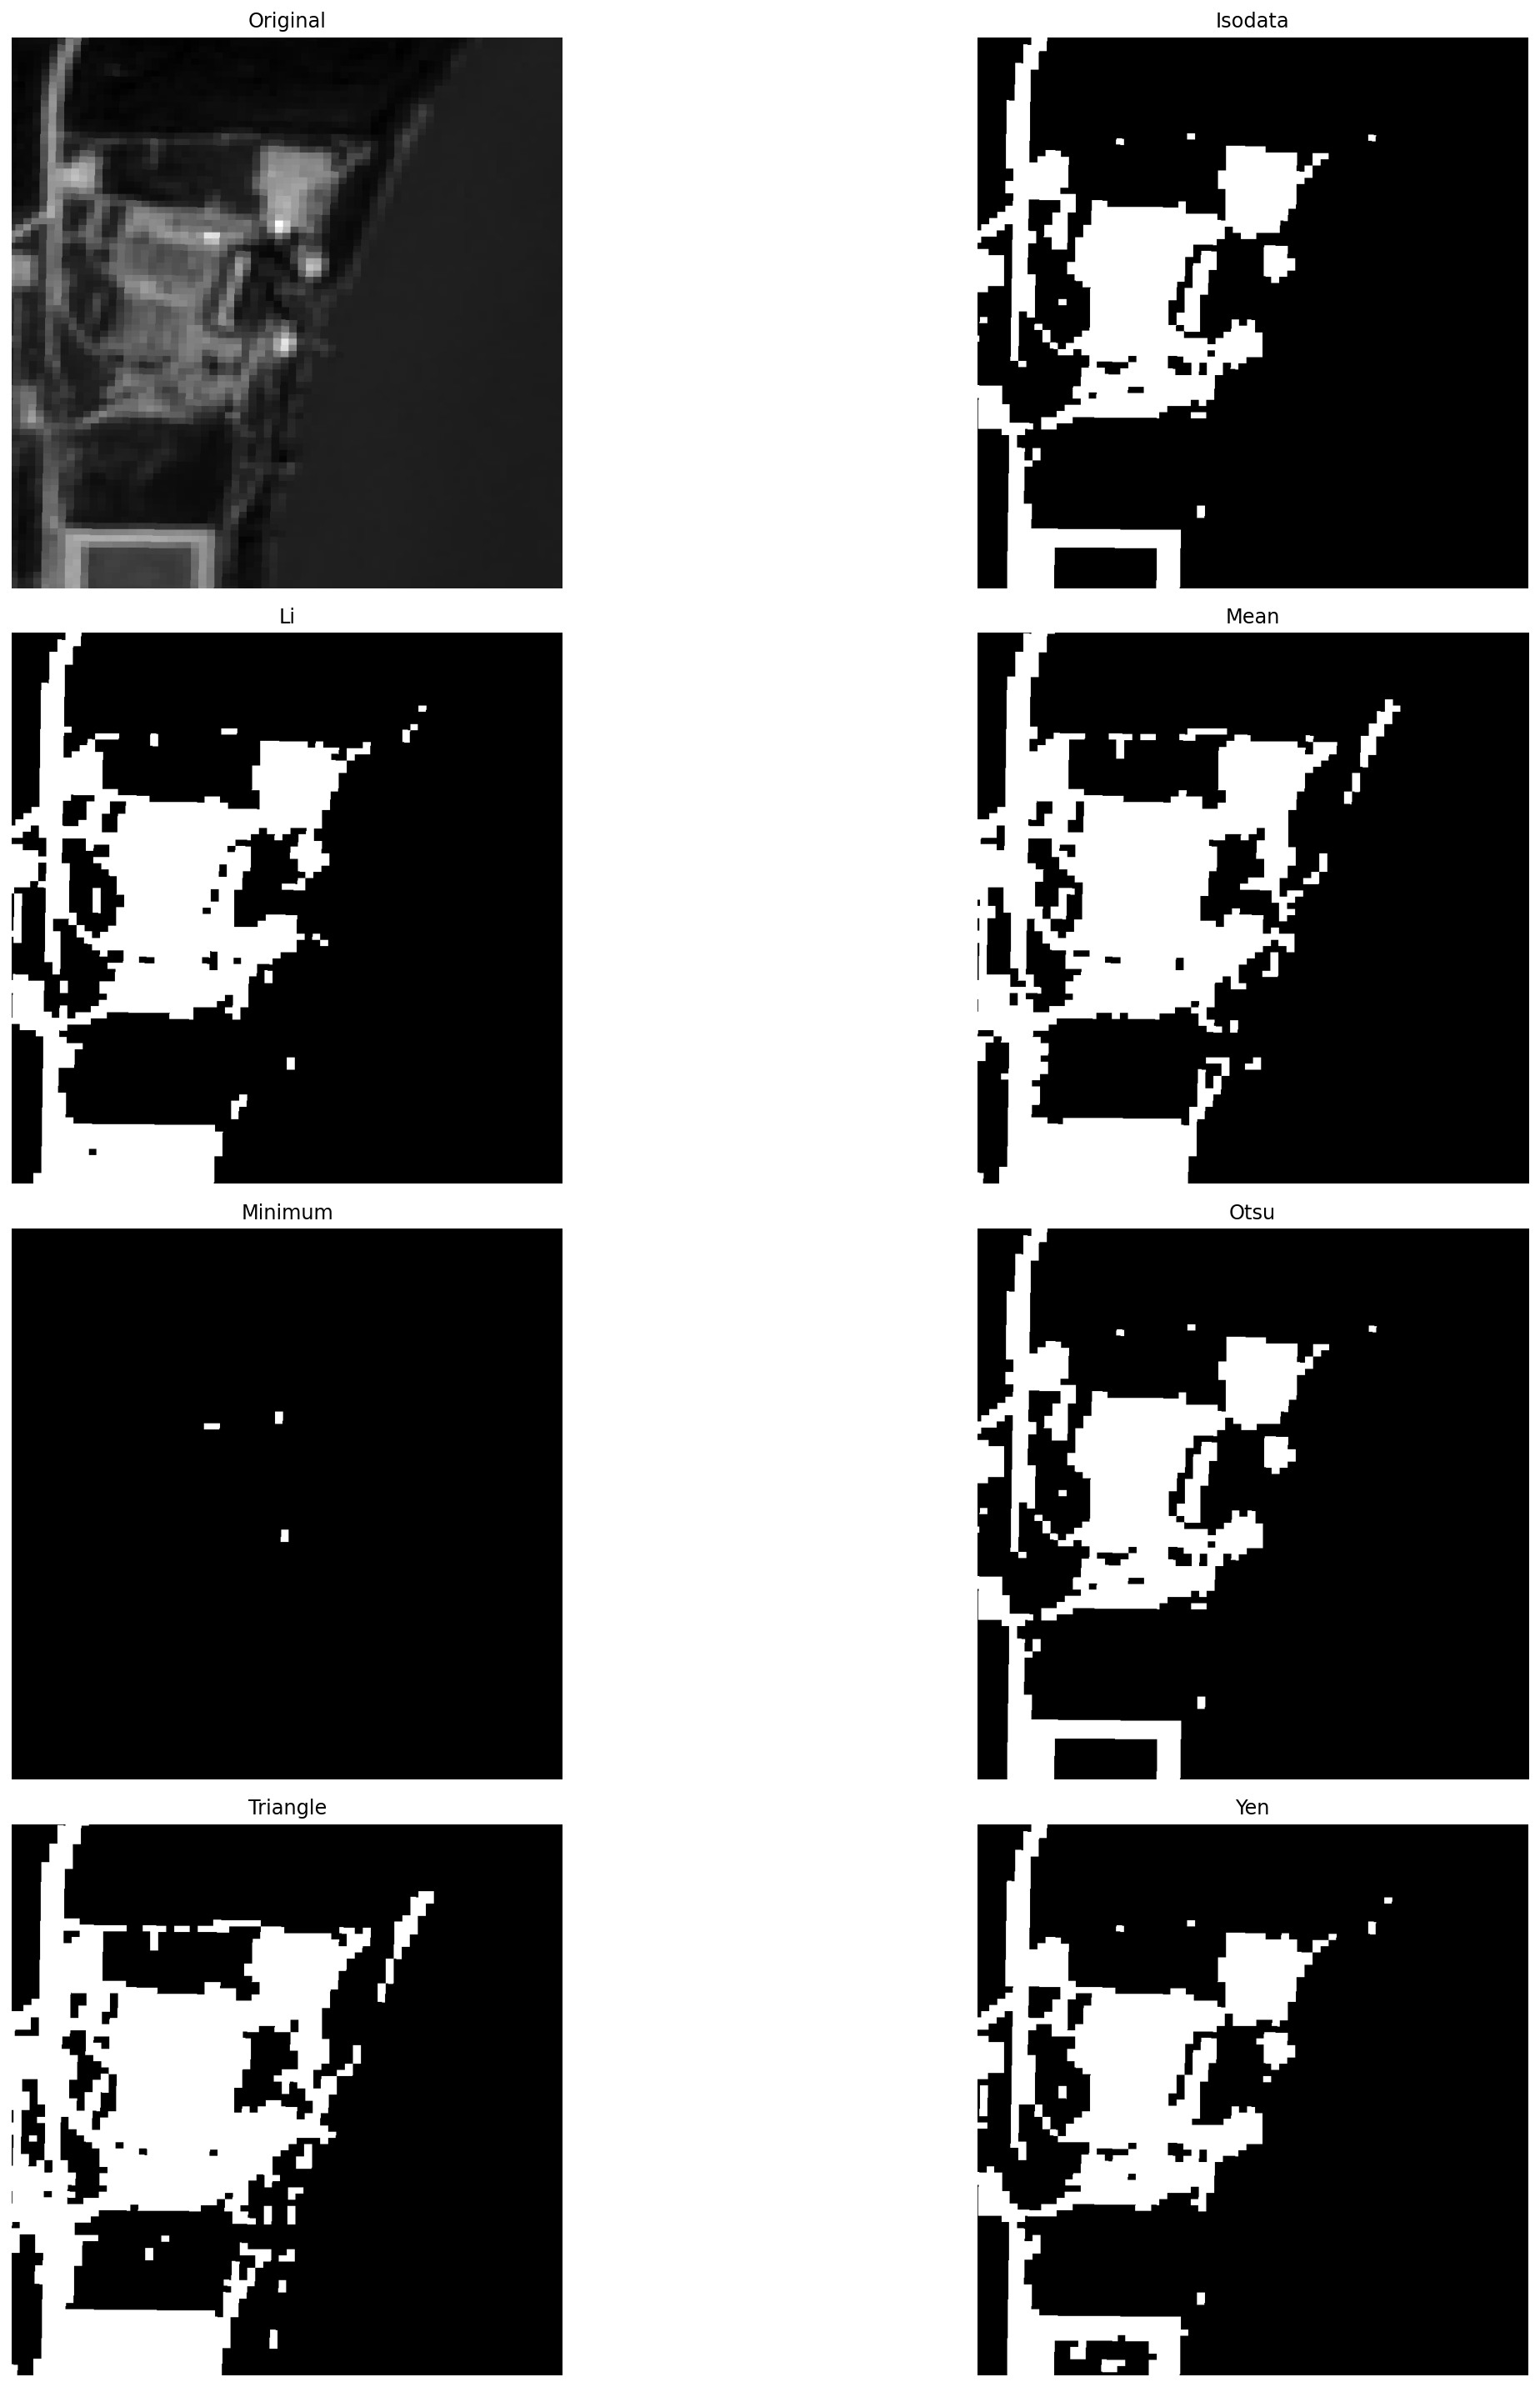

In [109]:
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(img_arr_bw, figsize=(20, 20), verbose=False)
plt.show()

#### Mean Value of Pixel Intensities

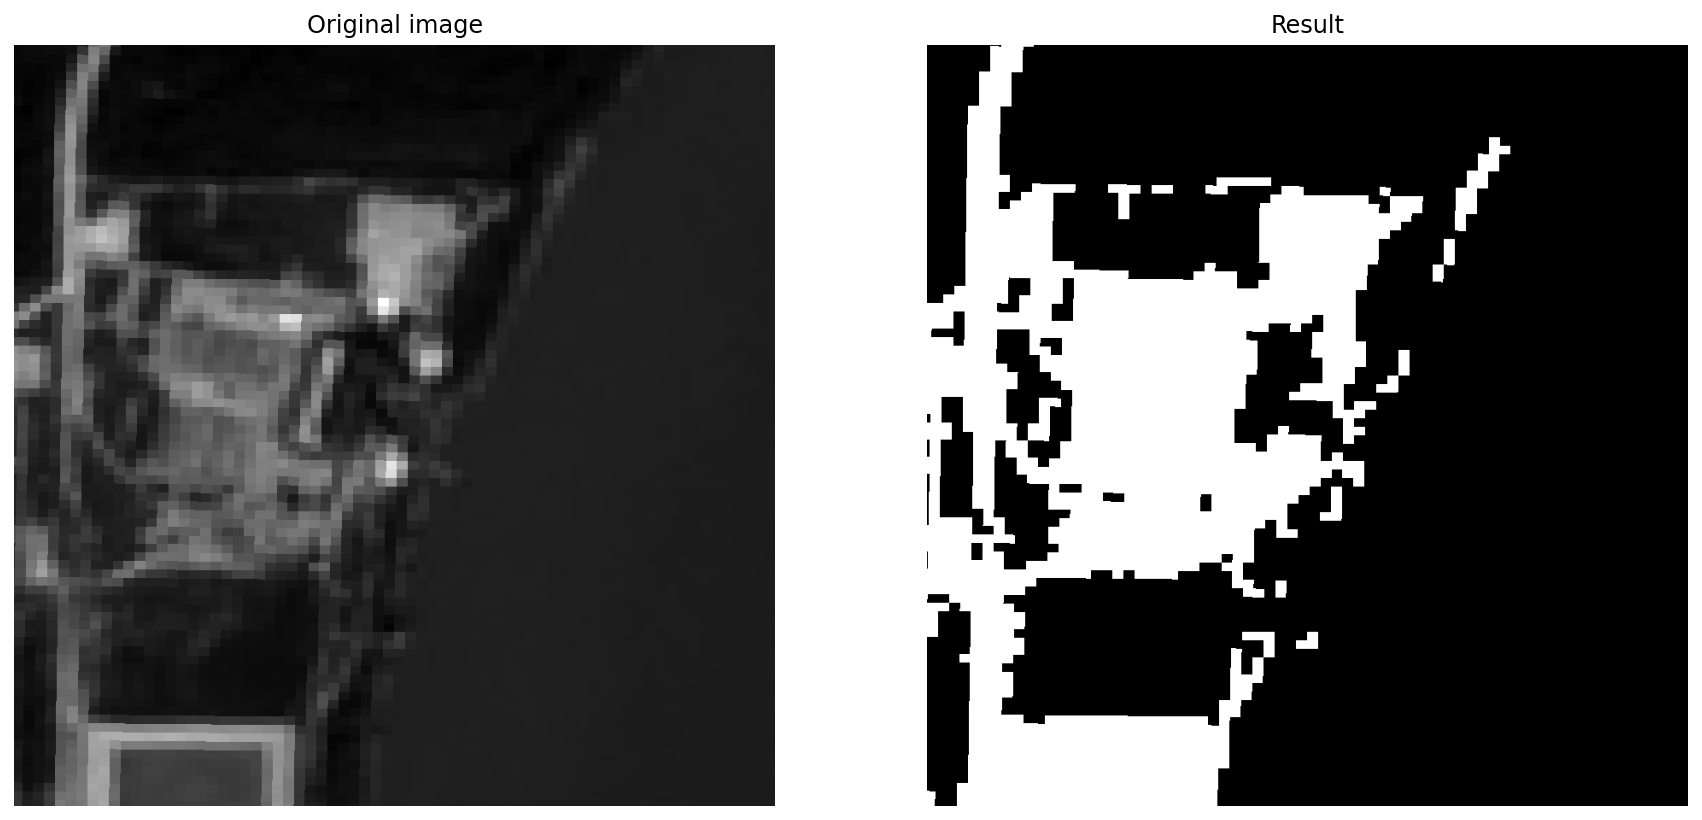

In [110]:
from skimage.filters import threshold_mean

thresh = threshold_mean(img_arr_bw)
binary = img_arr_bw > thresh

fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

#### Bimodal histogram
For pictures with a bimodal histogram, more specific algorithms can be used. For instance, the minimum algorithm takes a histogram of the image and smooths it repeatedly until there are only two peaks in the histogram.

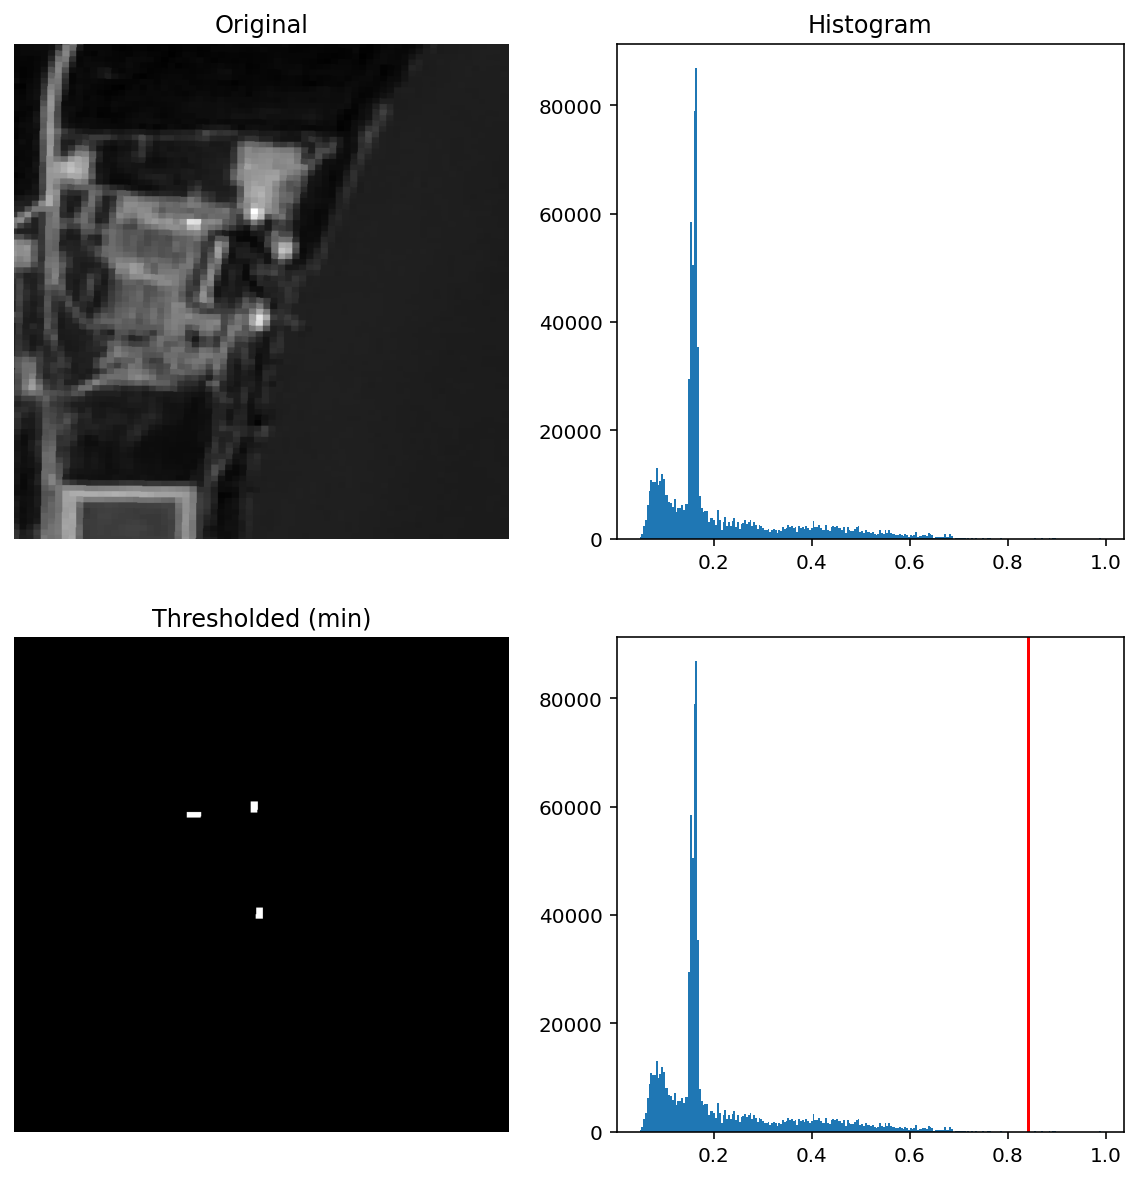

In [111]:
from skimage.filters import threshold_minimum

thresh_min = threshold_minimum(img_arr_bw)
binary_min = img_arr_bw > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(img_arr_bw.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(img_arr_bw.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

#### Otsu’s Method

Calculates an “optimal” threshold (marked by a red line in the histogram below) by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

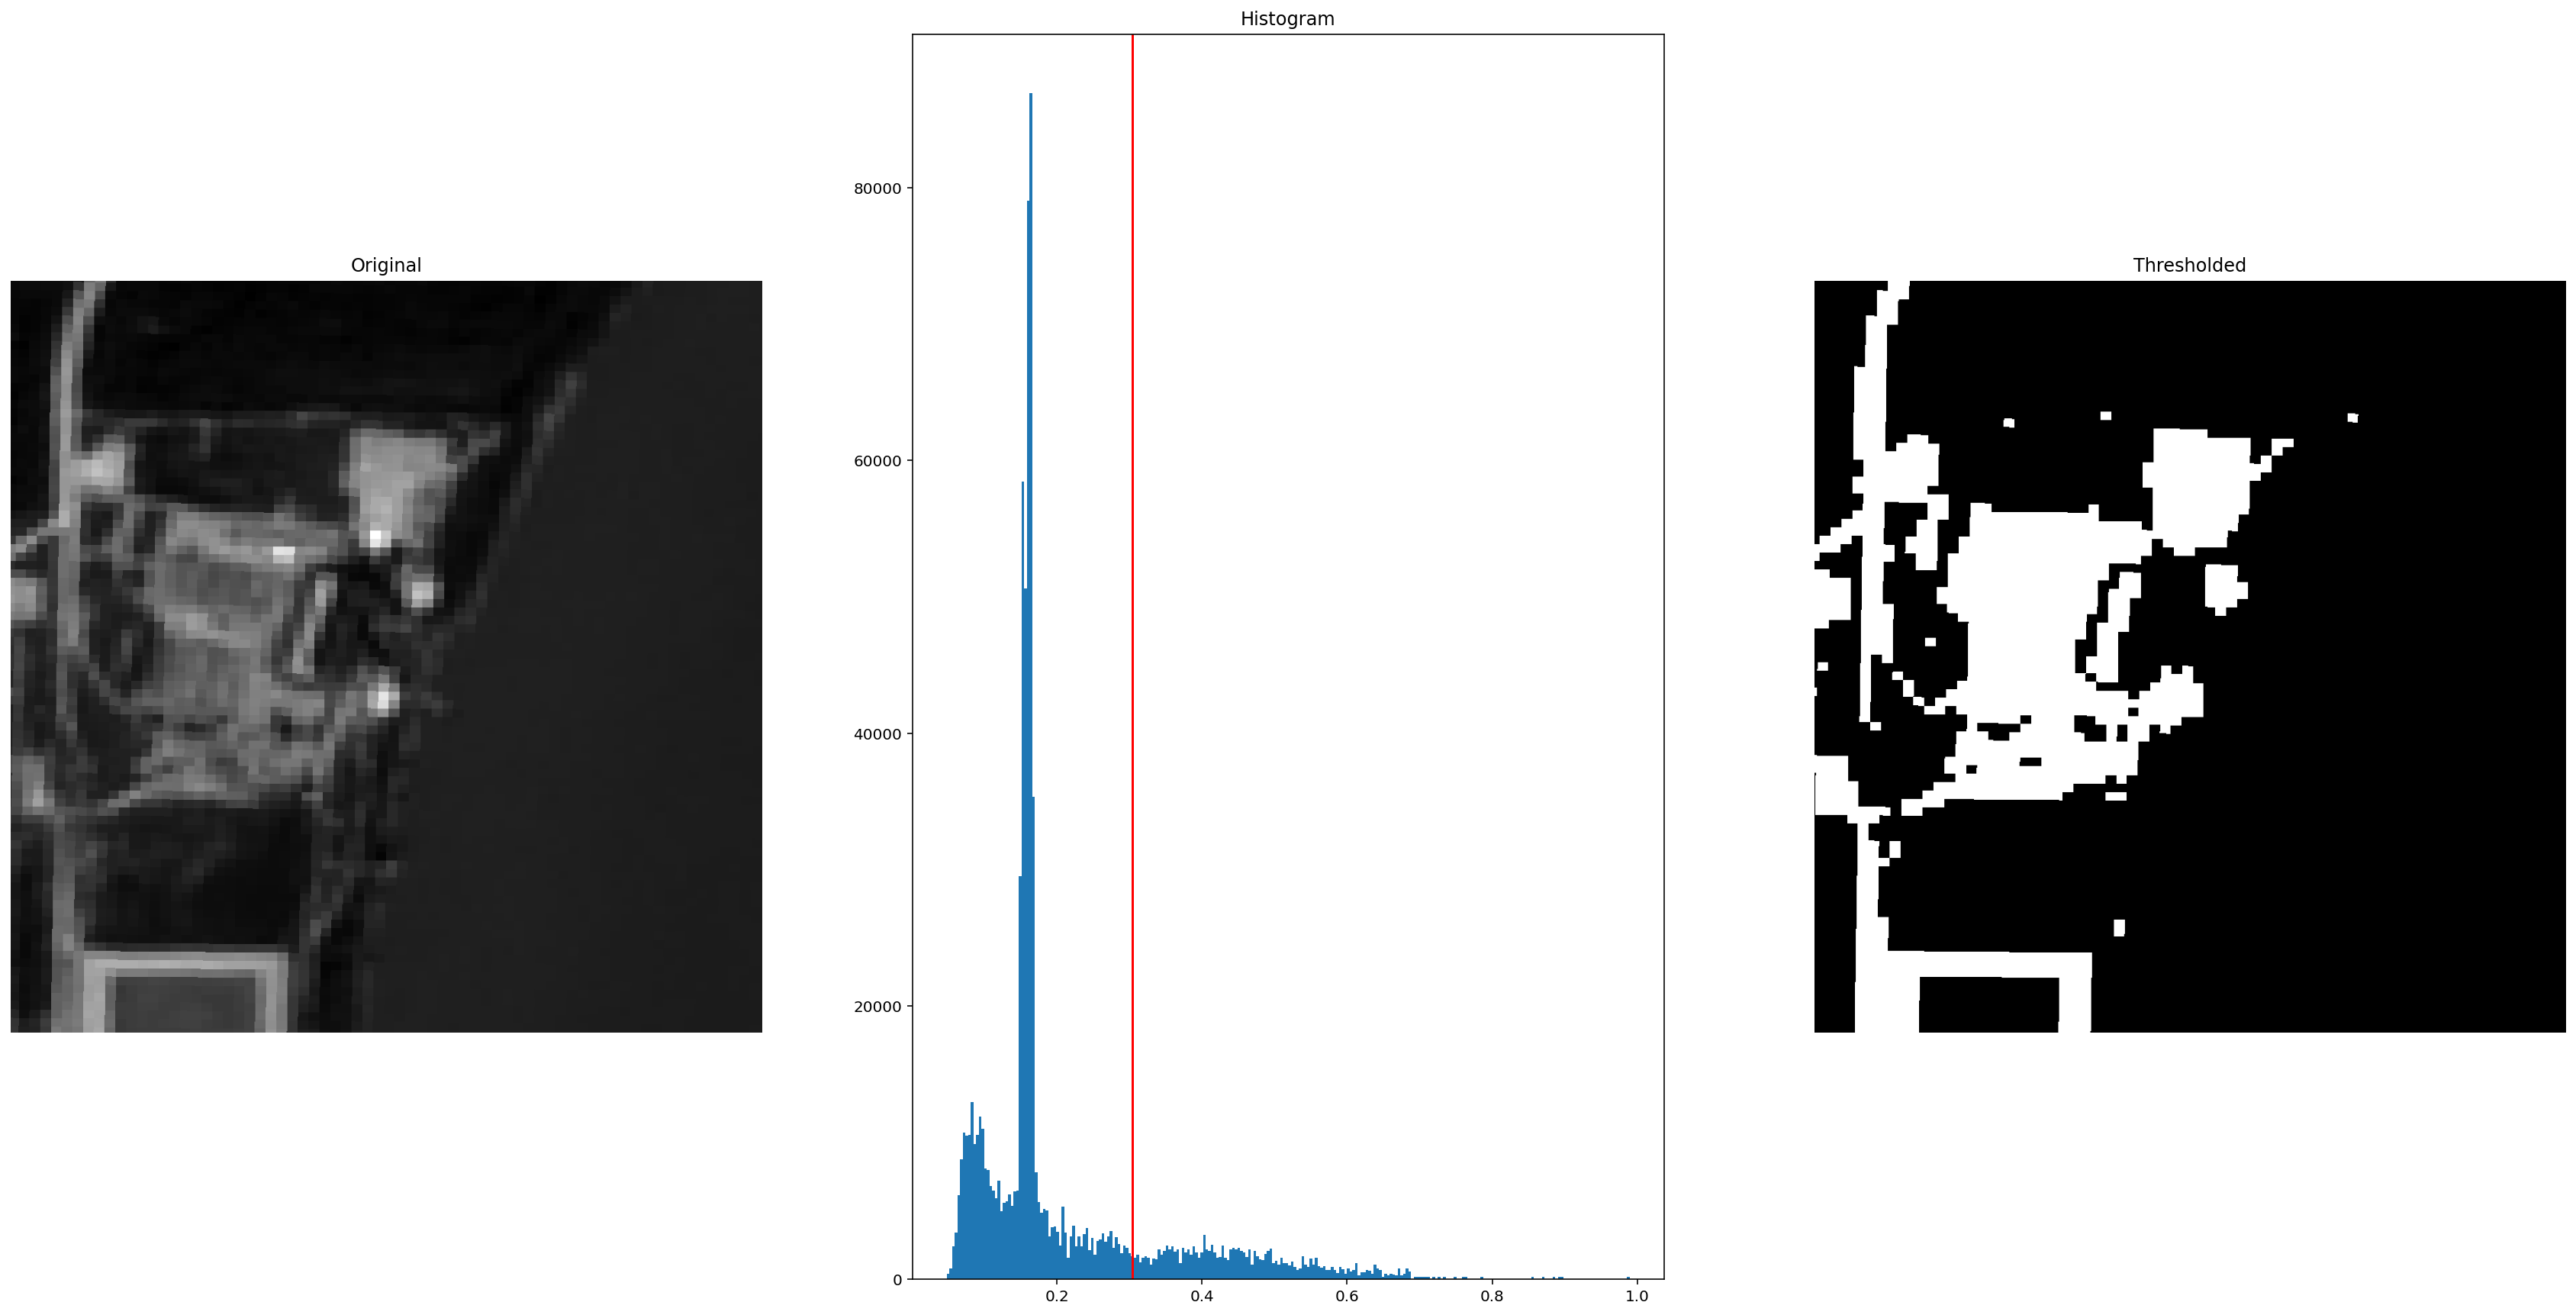

In [112]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_arr_bw)
binary = img_arr_bw > thresh

fig, axes = plt.subplots(ncols=3, figsize=(30, 15))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1, adjustable='box')
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box')

ax[0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(img_arr_bw.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Local Thresholding
If the image background is relatively uniform, then you can use a global threshold value as presented above. However, if there is large variation in the background intensity, adaptive thresholding (a.k.a. local or dynamic thresholding) may produce better results. Note that local is much slower than global thresholding.

Here, we binarize an image using the threshold_local function, which calculates thresholds in regions with a characteristic size block_size surrounding each pixel (i.e. local neighborhoods). Each threshold value is the weighted mean of the local neighborhood minus an offset value.

In [113]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,0.9999999))
image_array = scaler.fit_transform(img_arr_bw.reshape(-1, img_arr_bw.shape[-1])).reshape(img_arr_bw.shape)

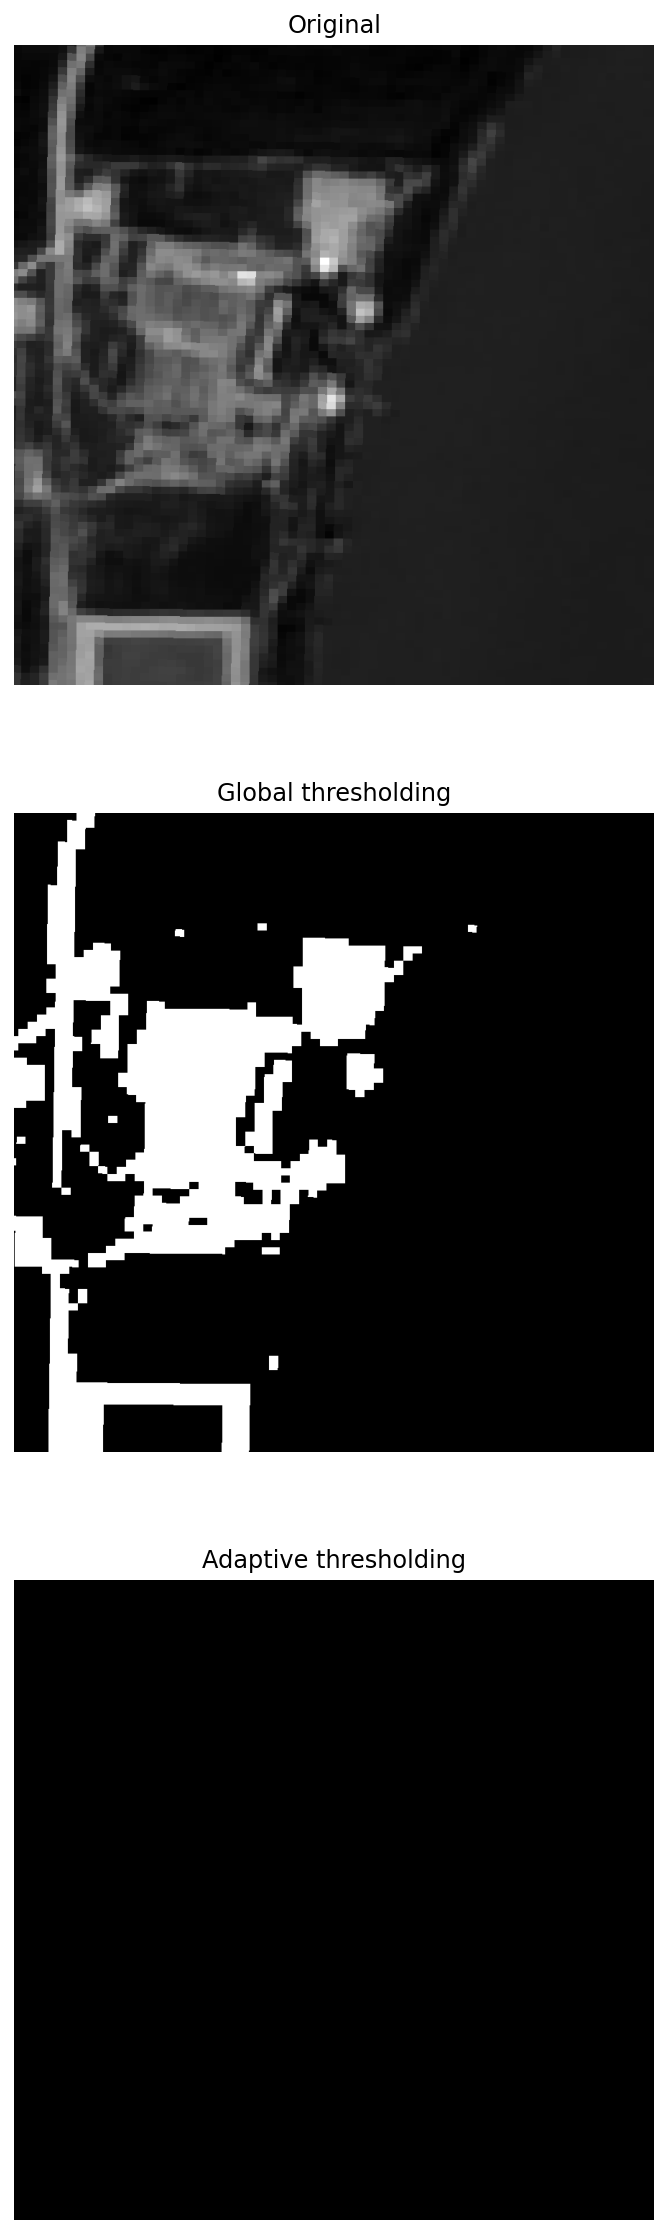

In [114]:
from skimage.filters import threshold_otsu, threshold_local

global_thresh = threshold_otsu(img_arr_bw)
binary_global = img_arr_bw> global_thresh

block_size = 35
adaptive_thresh = threshold_local(img_arr_bw, block_size, offset=10)
binary_adaptive = img_arr_bw > adaptive_thresh

fig, axes = plt.subplots(nrows=3, figsize=(10, 20))
ax = axes.ravel()
plt.gray()

ax[0].imshow(img_arr_bw)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_adaptive)
ax[2].set_title('Adaptive thresholding')

for a in ax:
    a.axis('off')

plt.show()

### Draw Line Using Angle

In [124]:
# Using Mean Value of Pixel Intensity
thresh = threshold_mean(img_arr_bw)
binary = img_arr_bw > thresh

In [125]:
# MEAN_SOLAR_AZIMUTH_ANGLE for Gallagher: 154.190793118437
azi_angle = 154.190793118437
angle = 90+abs(180-azi_angle)

In [126]:
angle

115.809206881563

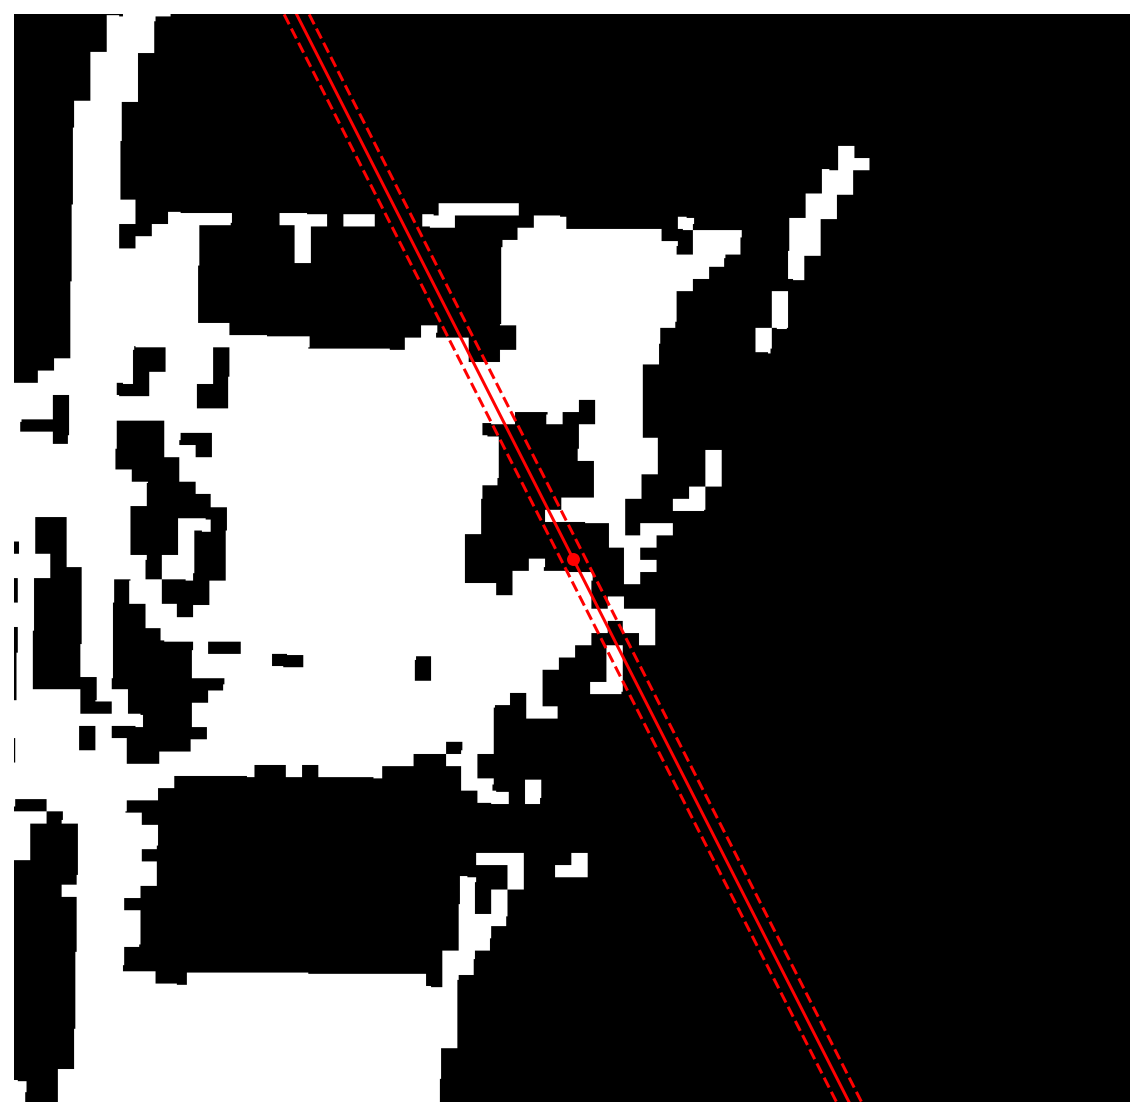

In [138]:
# draw lines on matplotlib plot
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(binary, aspect = 'auto', cmap ='gray')
plt.scatter(891/2,891/2, c='red', s=30)
plt.axline((891/2-10,891/2), slope=math.radians(angle), color='red', 
           label='axline', linestyle='dashed')
plt.axline((891/2,891/2), slope=math.radians(angle), color='red', 
           label='axline')
plt.axline((891/2+10,891/2), slope=math.radians(angle), color='red', 
           label='axline', linestyle='dashed')

### Miller

## Load Image as NumPy Array

In [139]:
# load image as numpy array
with rasterio.open('stacked_s2_sample.tif') as ds:
    img_arr = ds.read()  # read all raster values

In [140]:
img_arr.shape

(3, 892, 891)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


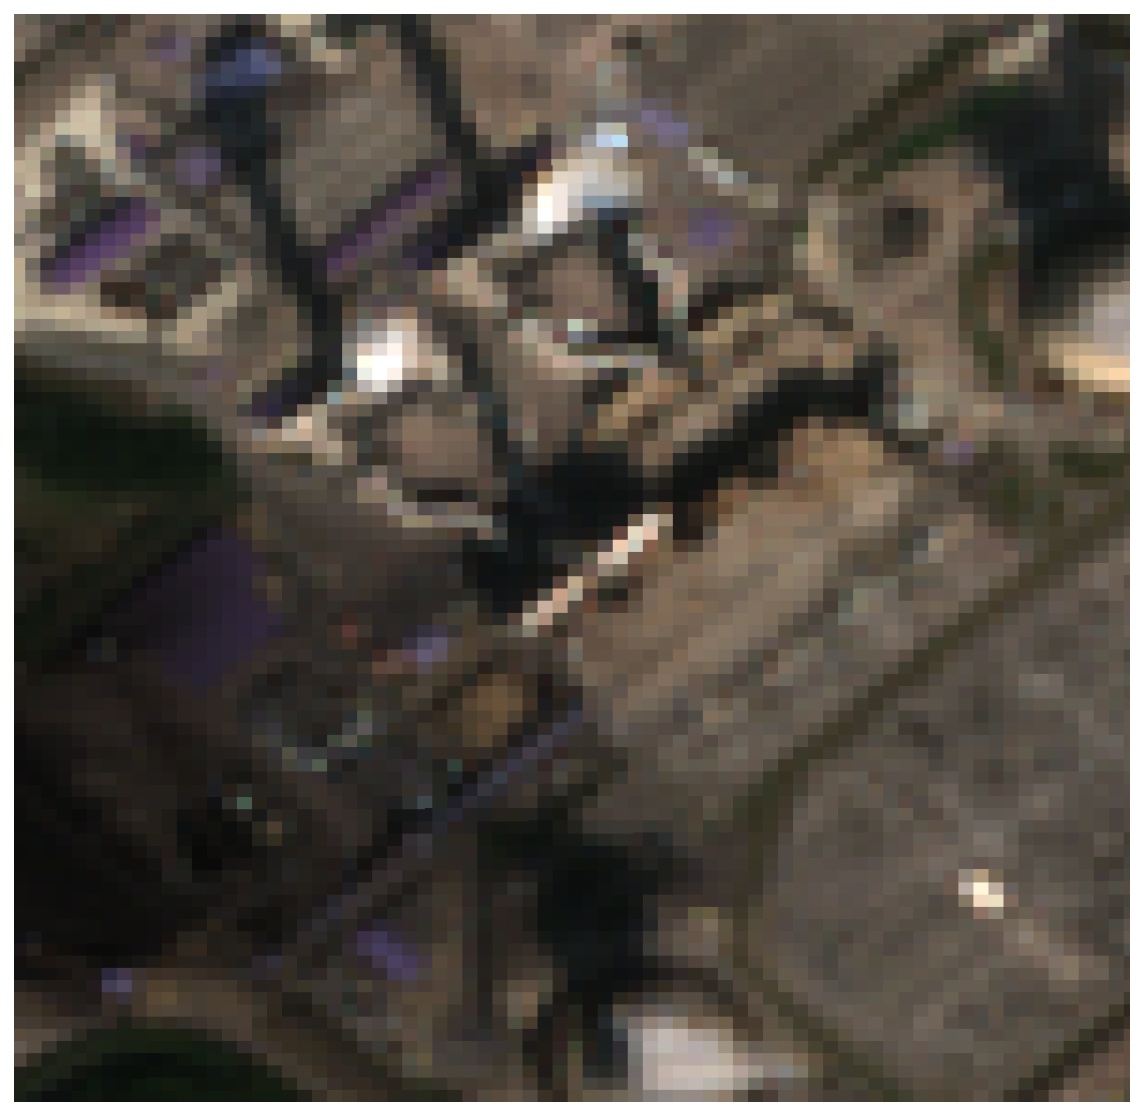

In [141]:
# try numpy swap axis, use this --> *move axis, roll axis
img_arr = np.moveaxis(img_arr, 0, -1)
img_arr = img_arr/4095
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_arr, aspect = 'auto')

In [142]:
img_arr.shape

(892, 891, 3)

### Convert image to grayscale?

In [143]:
# take average of each band -- create grayscale image
img_arr_bw = np.average(img_arr, weights=[0.1140, 0.5870, 0.2989], axis=2)

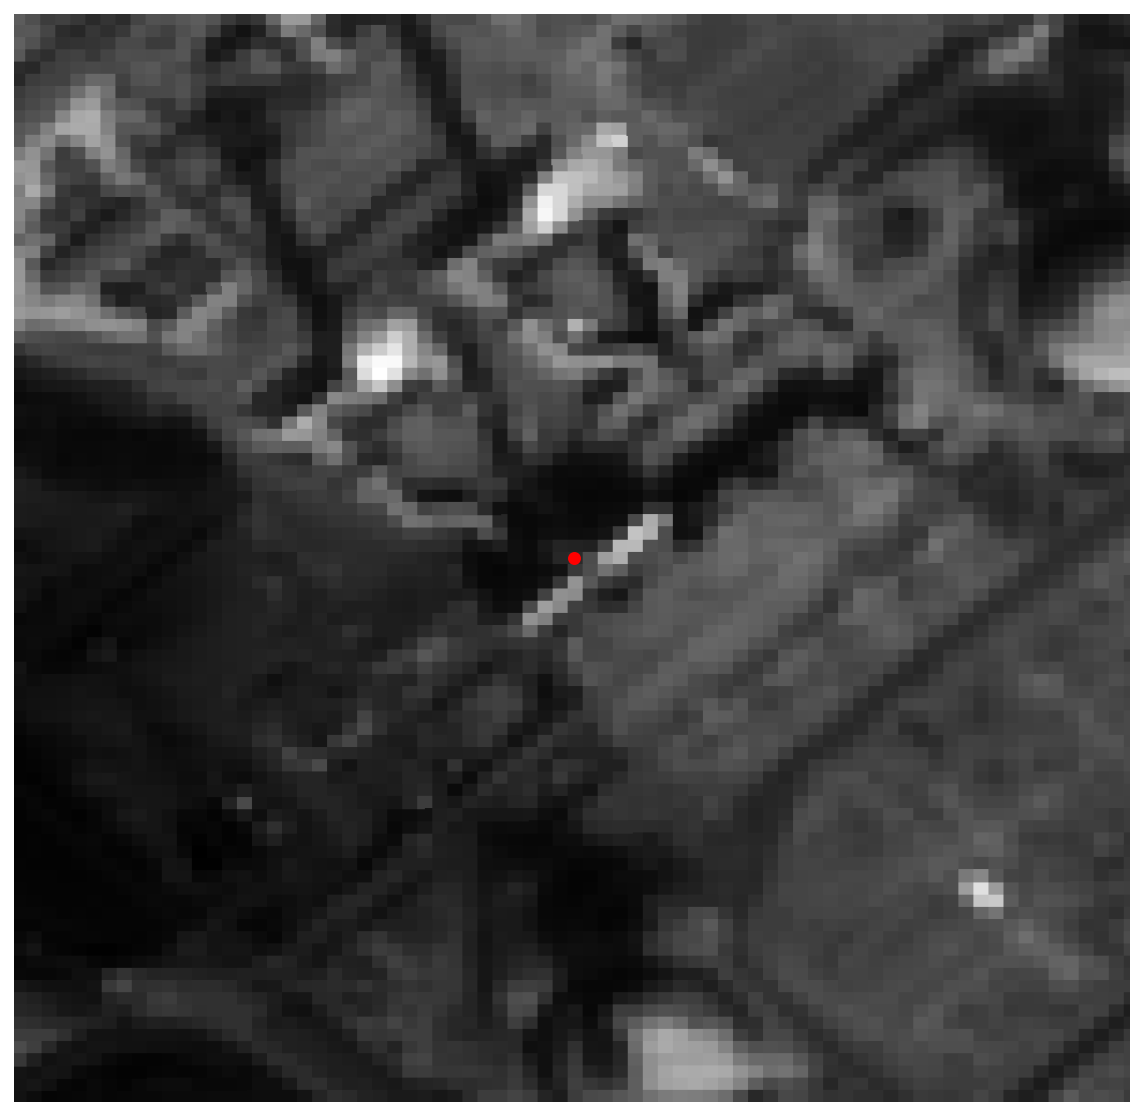

In [144]:
# true color of averaged image?
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_arr_bw, aspect = 'auto', cmap ='gray')
plt.scatter(892/2,891/2, c='red', s=30)
plt.show()

In [145]:
# select threshold
img_seg = np.where(img_arr_bw < 0.24, 0, 1)

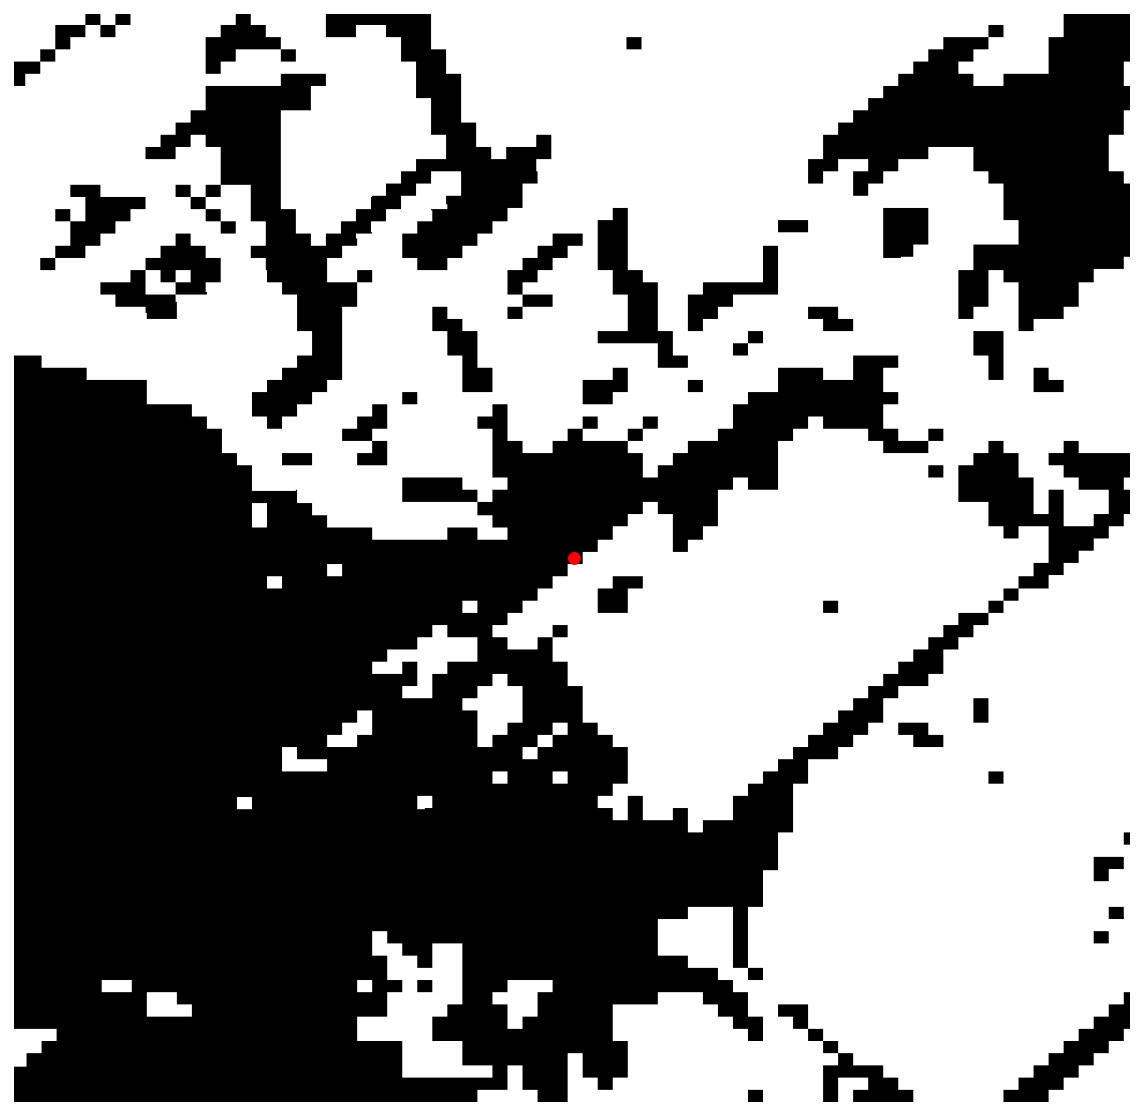

In [146]:
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_seg, aspect = 'auto', cmap ='gray')
plt.scatter(892/2,891/2, c='red', s=30)
plt.show()

### Thresholding Scikit Learn

Histogram-based: The histogram of the pixels’ intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal).

Local: To process a pixel, only the neighboring pixels are used. These algorithms often require more computation time.

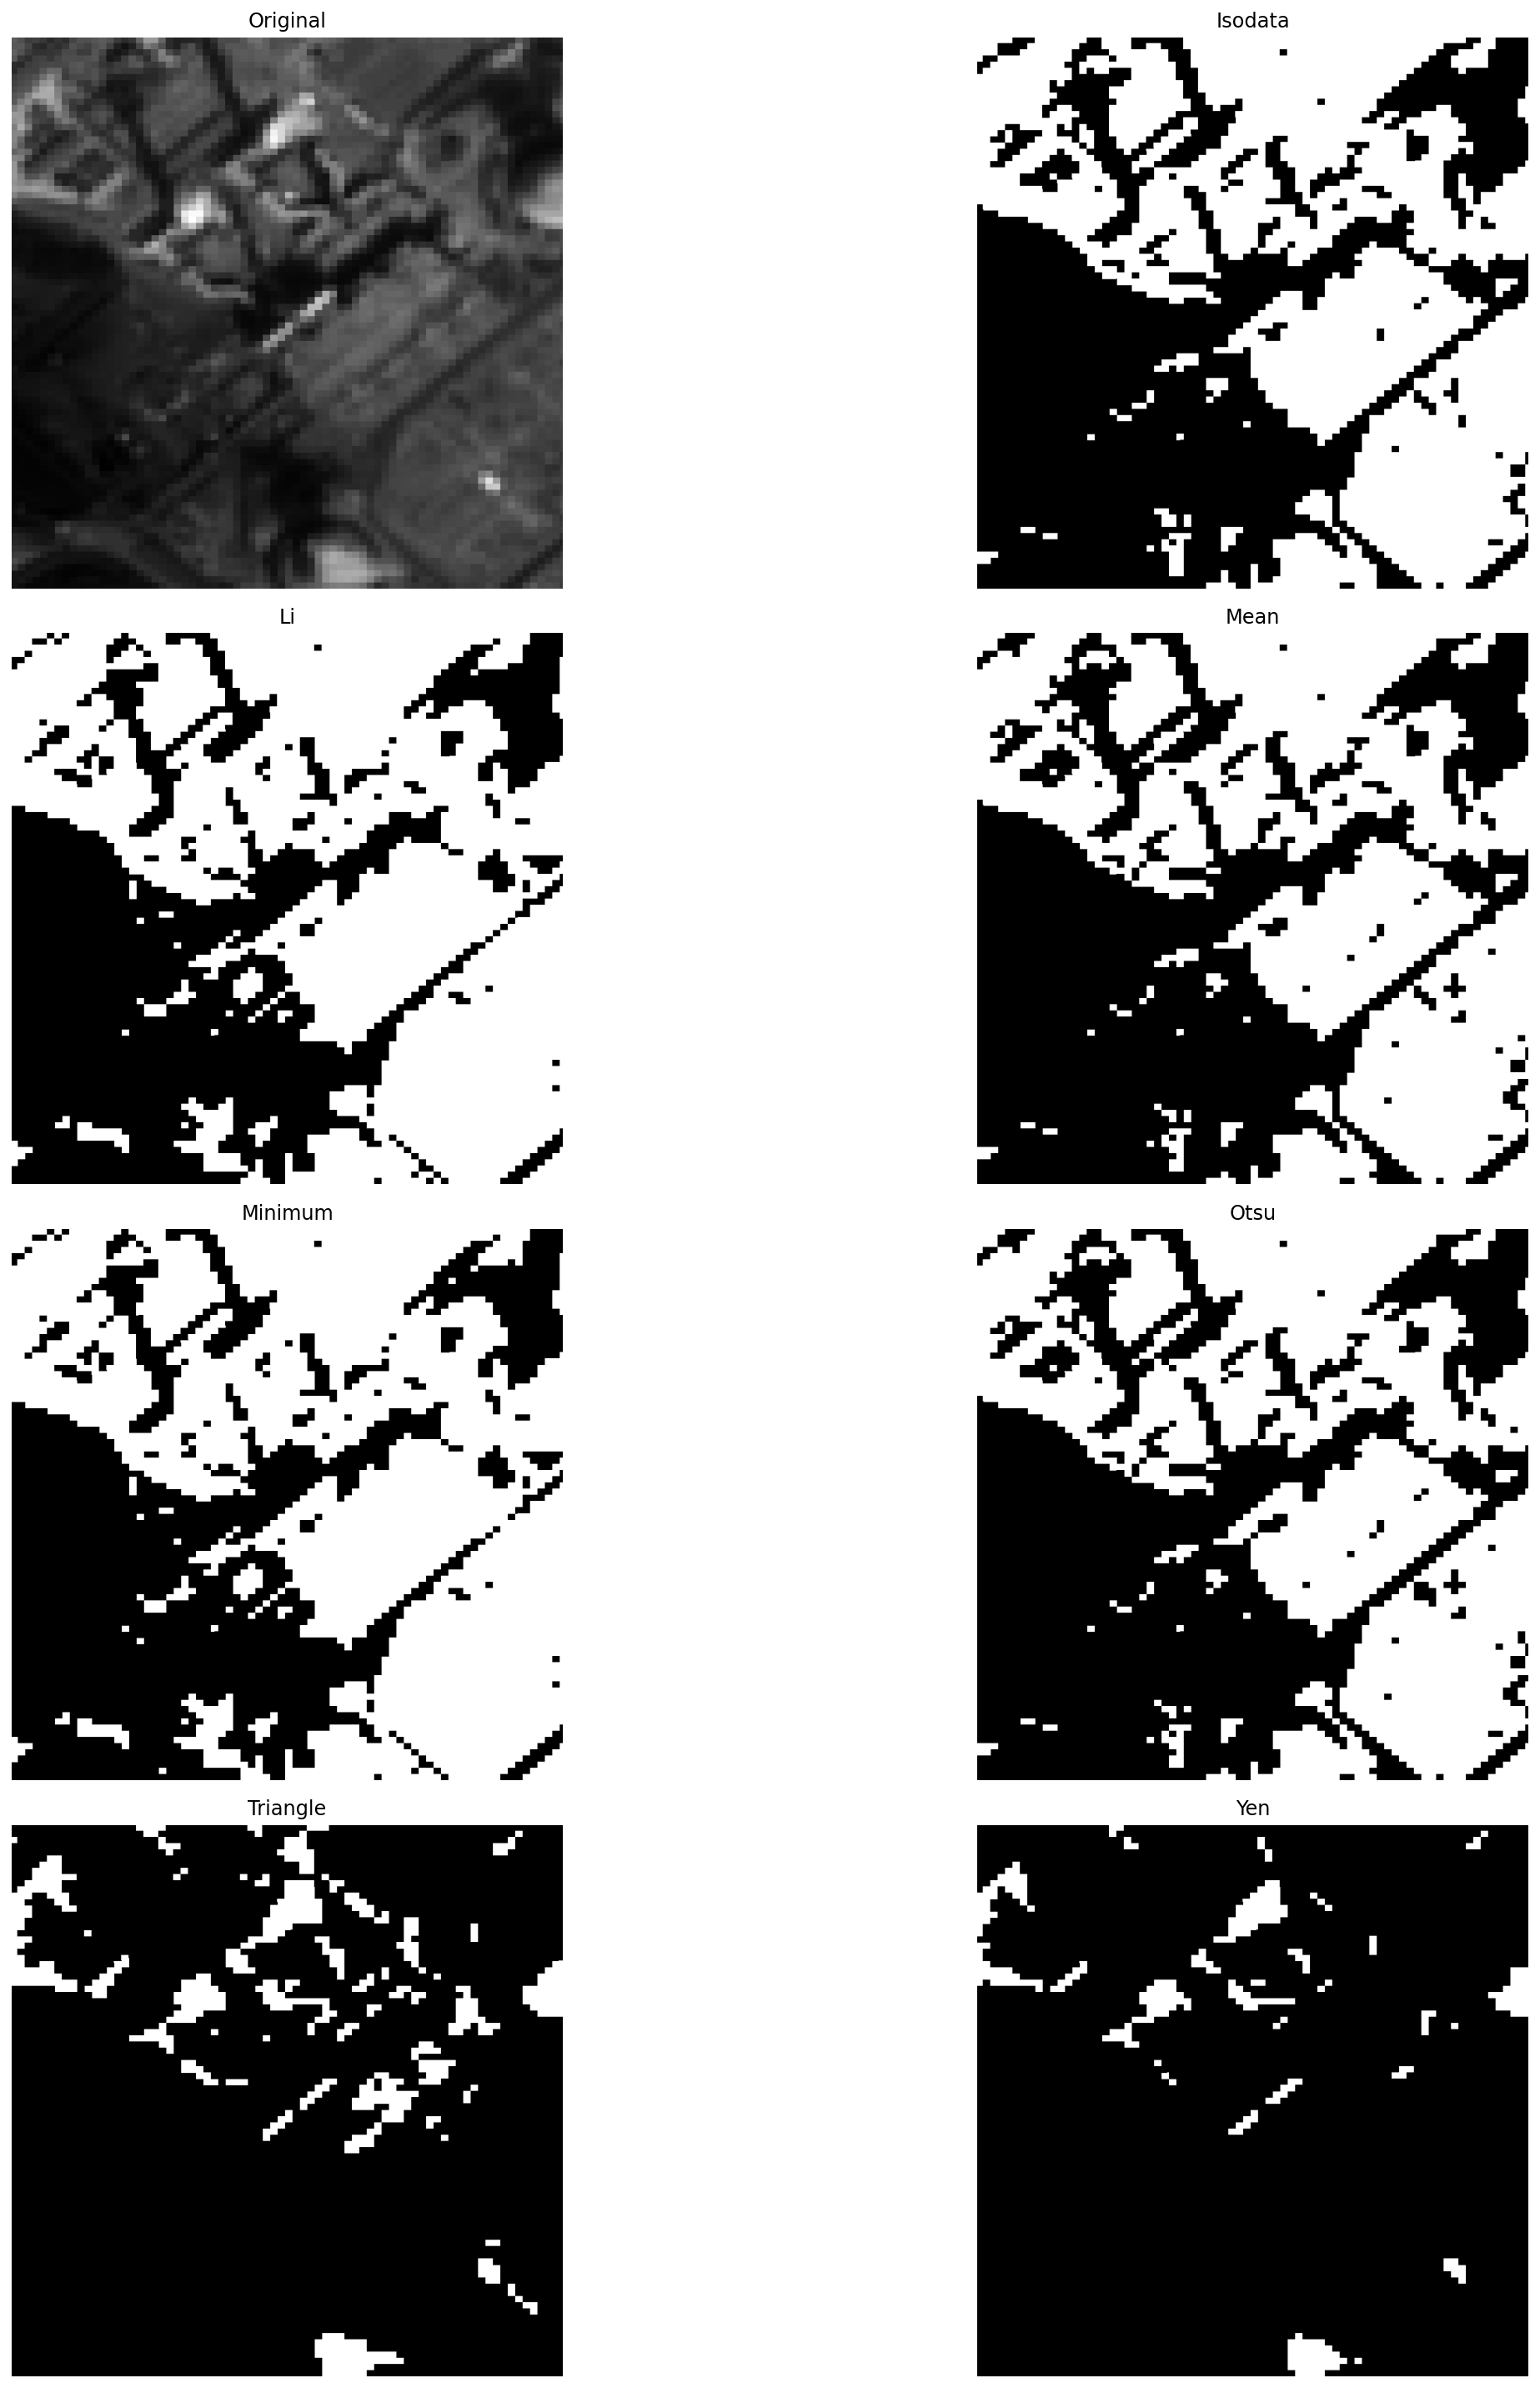

In [147]:
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(img_arr_bw, figsize=(20, 20), verbose=False)
plt.show()

#### Mean Value of Pixel Intensities

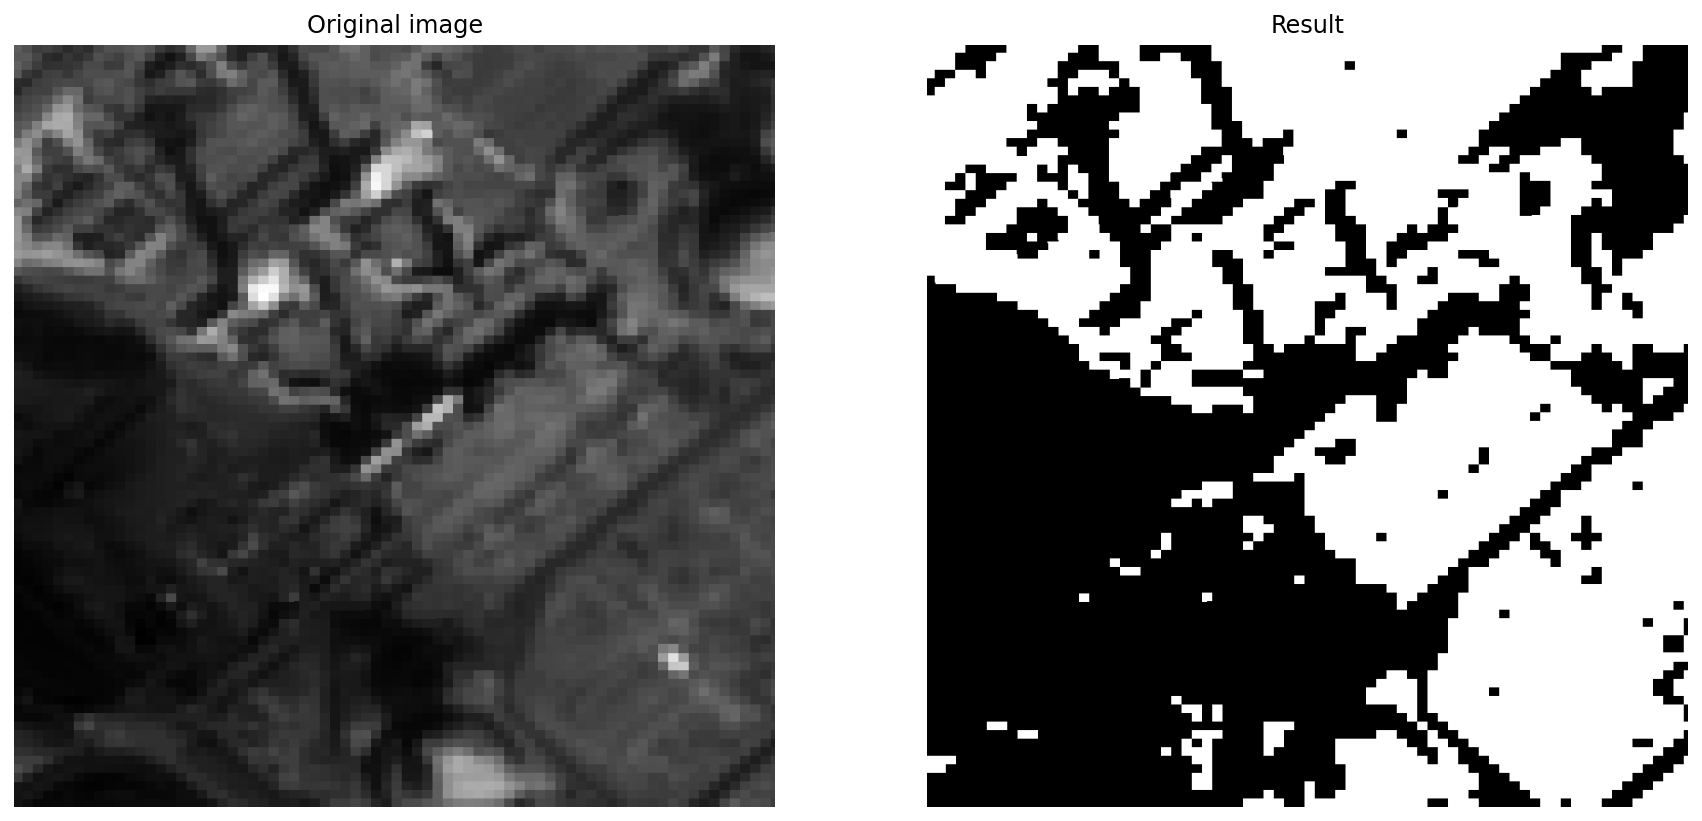

In [148]:
from skimage.filters import threshold_mean

thresh = threshold_mean(img_arr_bw)
binary = img_arr_bw > thresh

fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

#### Bimodal histogram
For pictures with a bimodal histogram, more specific algorithms can be used. For instance, the minimum algorithm takes a histogram of the image and smooths it repeatedly until there are only two peaks in the histogram.

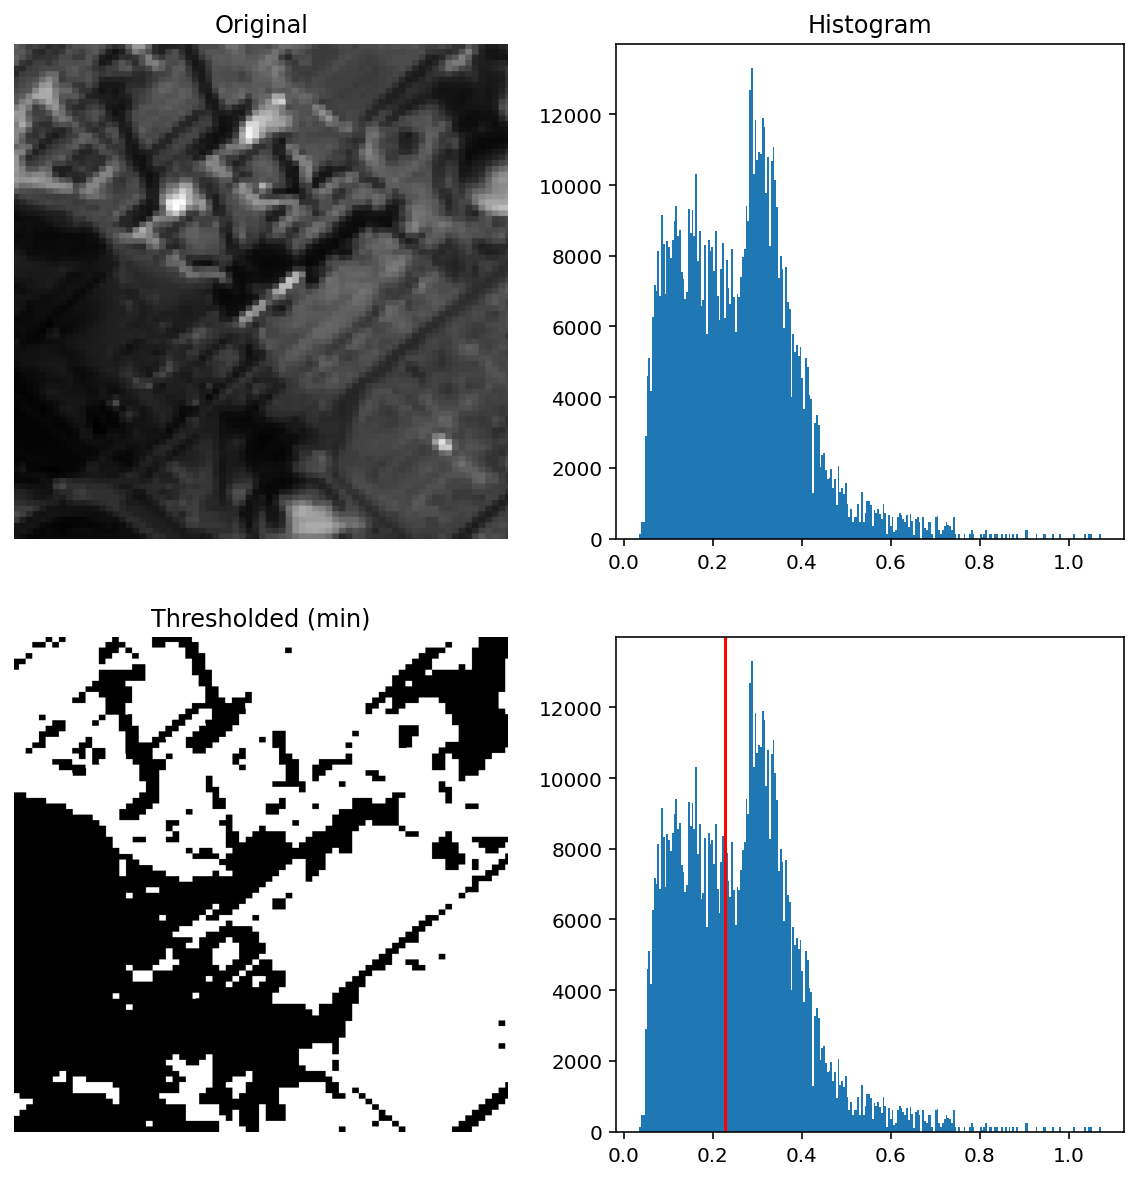

In [149]:
from skimage.filters import threshold_minimum

thresh_min = threshold_minimum(img_arr_bw)
binary_min = img_arr_bw > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(img_arr_bw.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(img_arr_bw.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

#### Otsu’s Method

Calculates an “optimal” threshold (marked by a red line in the histogram below) by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

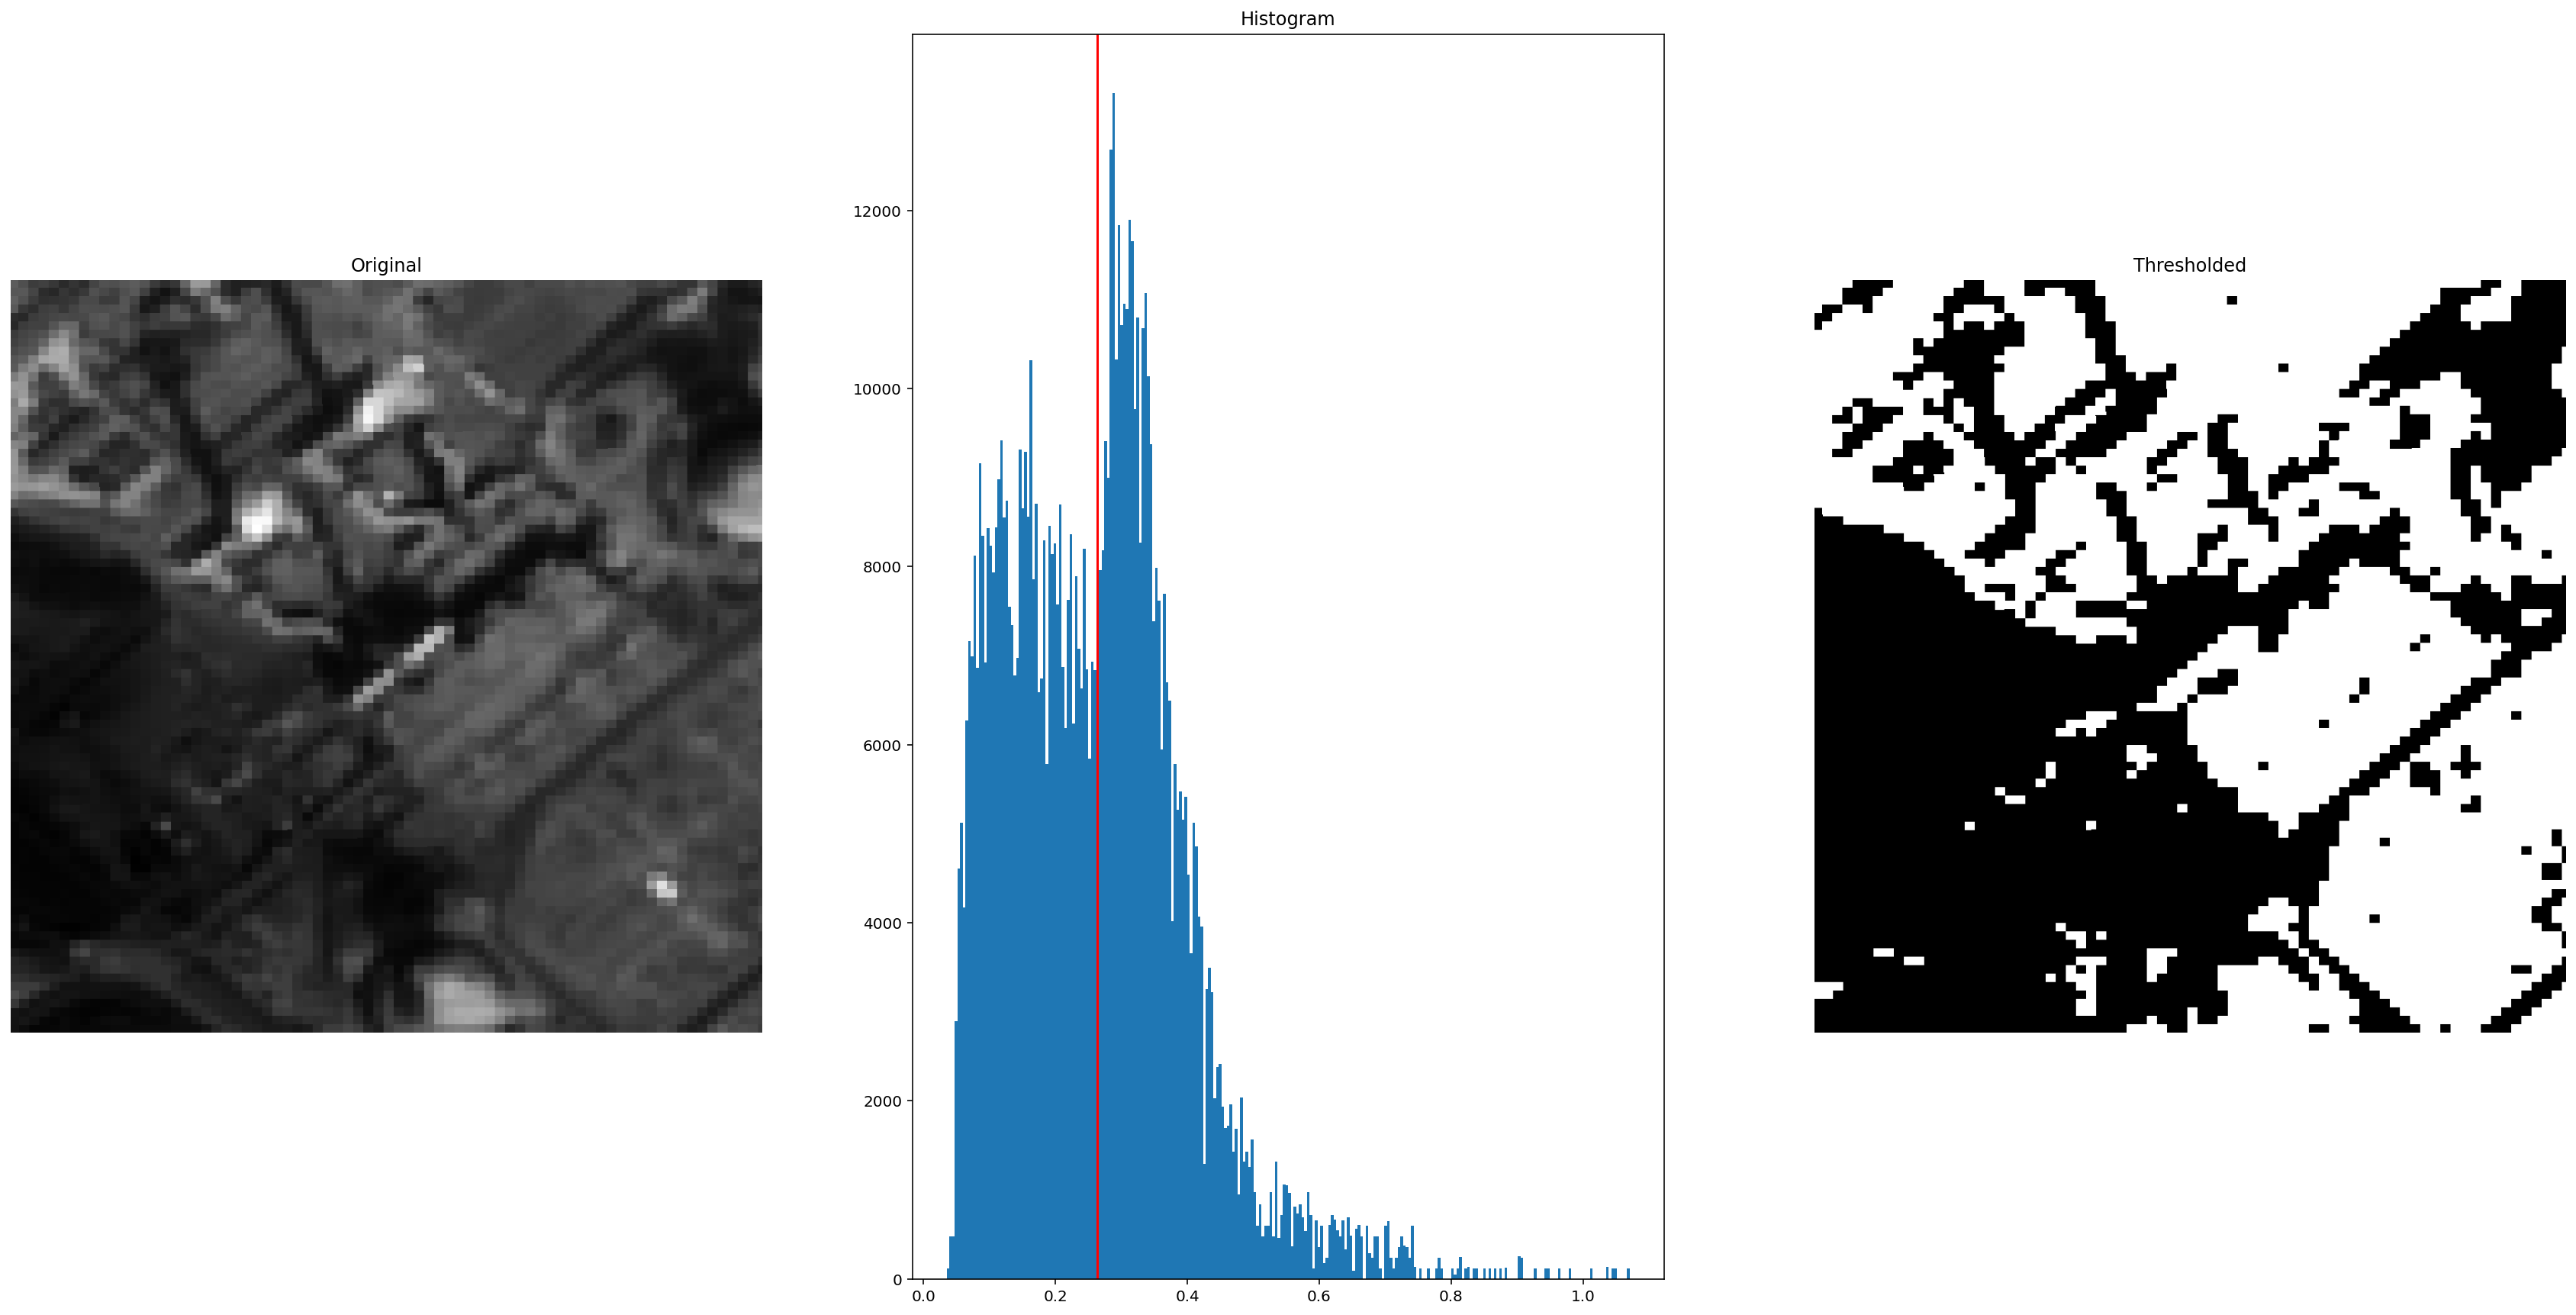

In [150]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_arr_bw)
binary = img_arr_bw > thresh

fig, axes = plt.subplots(ncols=3, figsize=(30, 15))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1, adjustable='box')
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box')

ax[0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(img_arr_bw.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Local Thresholding
If the image background is relatively uniform, then you can use a global threshold value as presented above. However, if there is large variation in the background intensity, adaptive thresholding (a.k.a. local or dynamic thresholding) may produce better results. Note that local is much slower than global thresholding.

Here, we binarize an image using the threshold_local function, which calculates thresholds in regions with a characteristic size block_size surrounding each pixel (i.e. local neighborhoods). Each threshold value is the weighted mean of the local neighborhood minus an offset value.

In [151]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,0.9999999))
image_array = scaler.fit_transform(img_arr_bw.reshape(-1, img_arr_bw.shape[-1])).reshape(img_arr_bw.shape)

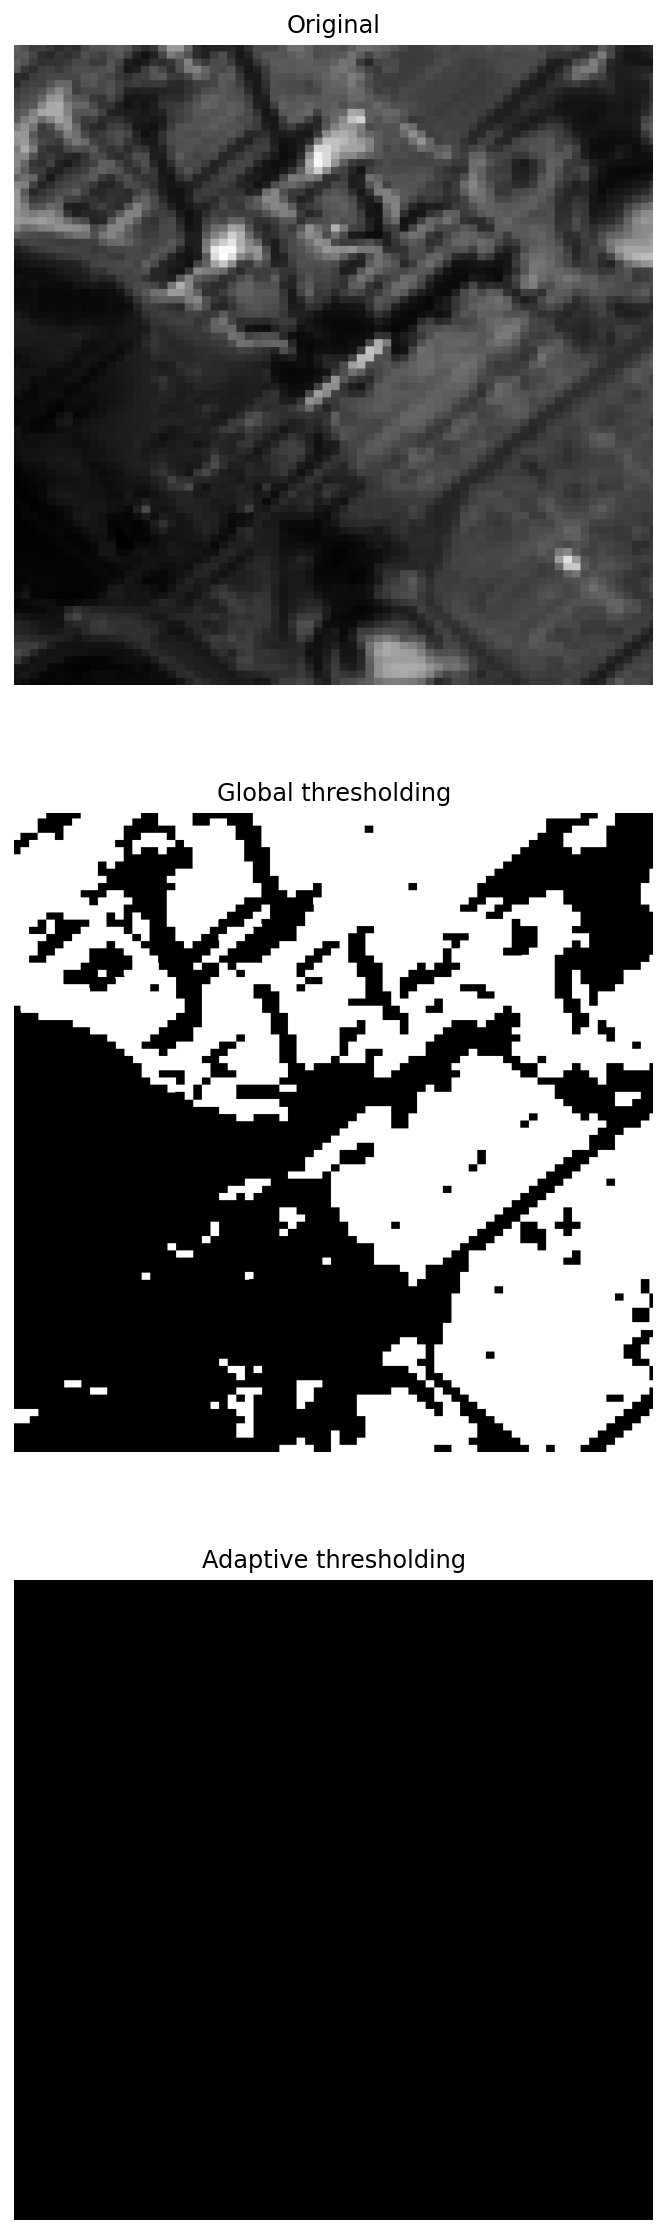

In [152]:
from skimage.filters import threshold_otsu, threshold_local

global_thresh = threshold_otsu(img_arr_bw)
binary_global = img_arr_bw> global_thresh

block_size = 35
adaptive_thresh = threshold_local(img_arr_bw, block_size, offset=10)
binary_adaptive = img_arr_bw > adaptive_thresh

fig, axes = plt.subplots(nrows=3, figsize=(10, 20))
ax = axes.ravel()
plt.gray()

ax[0].imshow(img_arr_bw)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_adaptive)
ax[2].set_title('Adaptive thresholding')

for a in ax:
    a.axis('off')

plt.show()

### Draw Line Using Angle

In [153]:
# Using Mean Value of Pixel Intensity
thresh = threshold_mean(img_arr_bw)
binary = img_arr_bw > thresh

In [154]:
# MEAN_SOLAR_AZIMUTH_ANGLE for Gallagher: 154.190793118437
azi_angle = 158.980095438294
angle = 90+abs(180-azi_angle)

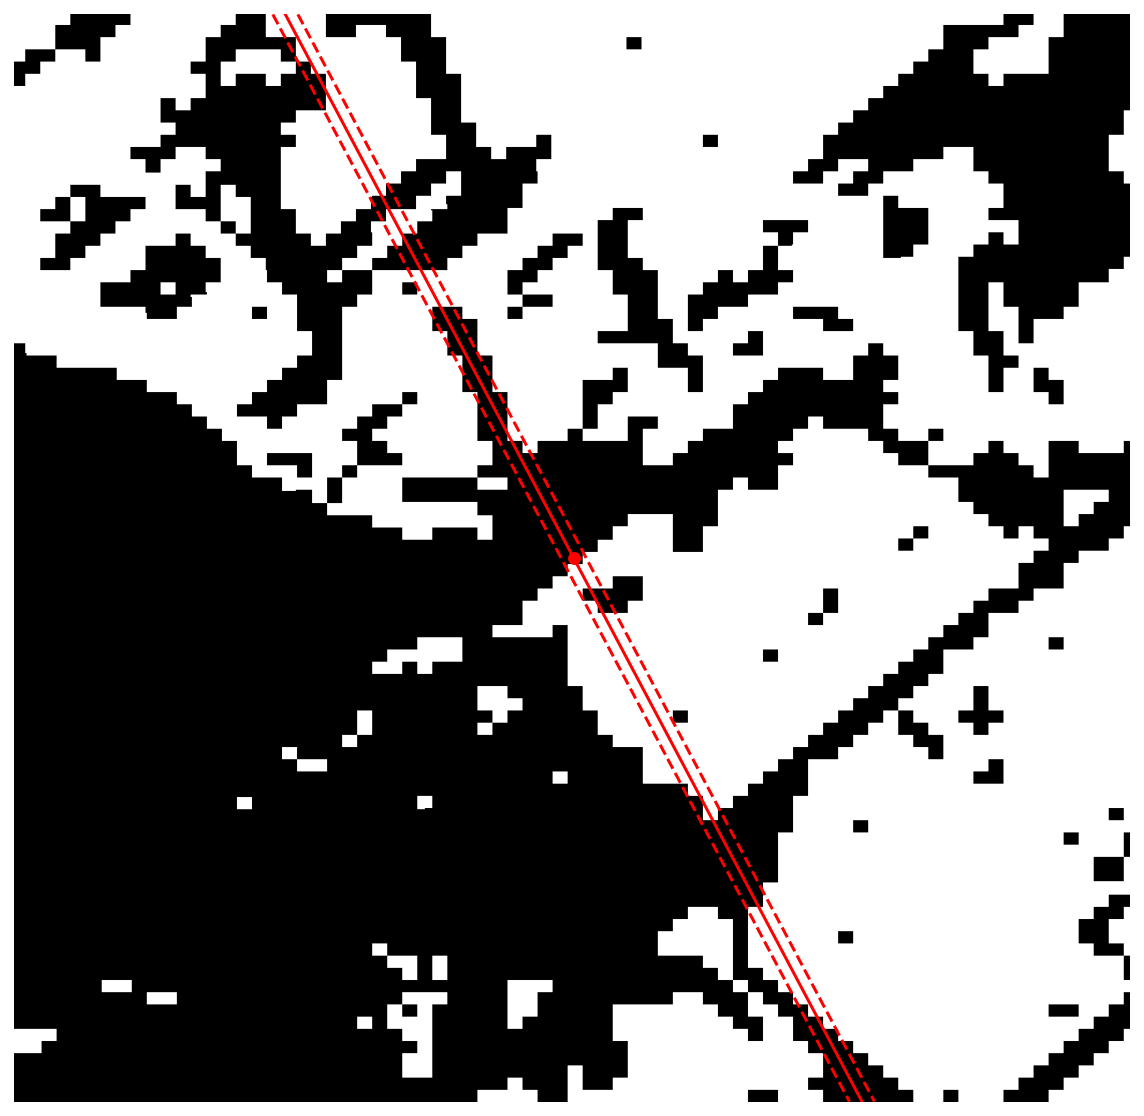

In [155]:
# draw lines on matplotlib plot
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(binary, aspect = 'auto', cmap ='gray')
plt.scatter(892/2,891/2, c='red', s=30)
plt.axline((892/2-10,891/2), slope=math.radians(angle), color='red', 
           label='axline', linestyle='dashed')
plt.axline((892/2,891/2), slope=math.radians(angle), color='red', 
           label='axline')
plt.axline((892/2+10,891/2), slope=math.radians(angle), color='red', 
           label='axline', linestyle='dashed')